In [1]:
'''
TODO

- nel calcolo del diametro karst per le trincee considerare la distanza tra m_s-l_m e bedrock (h_quat+h_perm-h_rilevato)
- introdurre una distribuzione exponenziale troncata
- nel calcolo a ritroso dividere le subsidenze dagli inbuti
- la def funziona per gli inbuti, fare una nuova def per le subsidenze
- capire come gestire quegli inbuti che dal calcolo a ritroso non hanno soluzione (ex coperture alte)
- cambiare nome h_rilevato con h_livelletta

'''

'\nTODO\n\n- nel calcolo del diametro karst per le trincee considerare la distanza tra m_s-l_m e bedrock (h_quat+h_perm-h_rilevato)\n- introdurre una distribuzione exponenziale troncata\n- nel calcolo a ritroso dividere le subsidenze dagli inbuti\n- la def funziona per gli inbuti, fare una nuova def per le subsidenze\n- capire come gestire quegli inbuti che dal calcolo a ritroso non hanno soluzione (ex coperture alte)\n- cambiare nome h_rilevato con h_livelletta\n\n'

In [2]:
#!/usr/bin/env conda run -n newenv3 python
import sys
print(sys.executable)    ### C:\ProgramData\Anaconda3_1\envs\newenv3\python.exe
#!{sys.executable} -m pip install tables              ##  df.to_hdf

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
!jupyter kernelspec list
# pip install xlrd
# python -m pip install --user numpy scipy matplotlib ipython jupyter pandas sympy nose

C:\ProgramData\Anaconda3_1\envs\newenv3\python.exe


Available kernels:
  python3    C:\ProgramData\Anaconda3_1\envs\newenv3\share\jupyter\kernels\python3


## Note

- Non può prevedere le caverne e gli eventi con probabilità bassa
- L'assunzione principale si basa sul fatto che:
        - i diametri di karst piccoli hanno una probabilità alta
        - i diametri di karst grandi hanno una prob. bassa
        - da qui l'assunzione di utilizzare una prob exp troncata ad un valore massimo

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from descartes import PolygonPatch
import math
from ipyleaflet import Map, GeoJSON
import geojson
import numpy as np
#from mpl_toolkits.basemap import Basemap
from ipyleaflet import Map
import mpld3
from dbfread import DBF
mpld3.enable_notebook()
#to import the basemap library give the direct path to the library
# import os
# os.environ["PROJ_LIB"]="C:\\Users\\Anaconda3\\Library\\share"
import pandas as pd
from simpledbf import Dbf5
import math
from Finddistribution import *
import numpy as np

from scipy.stats import expon
import matplotlib.pyplot as plt

import os
import types

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon


import plotly.graph_objects as go
from scipy.interpolate import griddata
from pyproj import Proj
import plotly.express as px

import random
from tqdm import tqdm

import sys
from tqdm import trange
import seaborn as sns

from IPython.display import display
pd.options.display.max_columns = None

from scipy.stats import gaussian_kde

import warnings
warnings.filterwarnings('ignore')

SQLalchemy is not installed. No support for SQL output.


#### Variabili globali

In [4]:
# limite di altezza per distinguere tra viadotti alti e bridge bassi
lim_via_bridge = 12.5

vitautile = 100

# soglia_dia_karst per differenziare karst small da karst grandi
soglia_dia_karst = 3
#1000
epochs = 100
#109
pkfinale = 41

### INIZIO

In [5]:
df_orig = pd.read_csv('Tabella_completa_karst2_3.csv', sep=';', index_col=0)

In [6]:
col_list = ['Road_level','m_s_l_m_','calc_top','gessi_top','marne_top','Arg_perm','Arg_giura','h_perm','h_calc','h_gessi','h_giur','h_quat','h_marne']

for col in col_list:
    df_orig[col] = round(df_orig[col].astype('float'),1)

In [7]:
df_orig['h_rilevato'] = df_orig['Road_level'] - df_orig['m_s_l_m_']

#### Creo df_orig

In [8]:
df_orig.columns

Index(['pk', 'zone', 'Intensity', 'STB_100Yr', 'Int_simpl', 'm_s_l_m_', 'Tipo',
       'Tipo_plus', 'progressiva', 'dist_sez', 'calc_top', 'gessi_top',
       'Arg_perm', 'Arg_giura', 'marne_top', 'Road_level', 'IGE_OLD', 'IGE',
       'Litho', 'IGE_sec', 'IGE_SEC_PERC', 'LITHO_SEC', 'POINT_X', 'POINT_Y',
       'sequenza', 'h_quat', 'h_marne', 'h_giur', 'h_perm', 'h_calc',
       'h_gessi', 'h_rilevato'],
      dtype='object')

In [9]:
df = df_orig[['IGE', 'Litho', 'IGE_sec', 'IGE_SEC_PERC', 'LITHO_SEC', 'POINT_X', 'POINT_Y','h_quat','Tipo','Tipo_plus','h_rilevato']]

In [10]:
# # se non trova la colonna Tipo_plus usare questo script
# df_temp_tipo = pd.read_csv('df_tipo_plus.csv', index_col=0)
# df['Tipo_plus'] = df_temp_tipo['Tipo_plus']

In [11]:
df['h_perm'] = df_orig.loc[:,['h_perm']].values + df_orig.loc[:,['h_giur']].values + df_orig.loc[:,['h_marne']].values

In [12]:
def f(row):
    if row['gessi_top'] > row['calc_top']:
        val = 'g'
    else:
        val = 'c'
    return val

df['bedrock'] = df_orig.apply(f, axis=1)

#### Correggo gli spessori negativi per errore precisione Leader / profilo GEO

In [13]:
df.loc[df['h_quat']<0,['h_quat']] = 0
df.loc[df['h_perm']<0,['h_perm']] = 0

#### Creo Dataframe con le proprietà meccaniche

In [14]:
#### Creo un dataframe con le proprietà meccaniche

df_prop = pd.read_csv('df_prop.csv', sep=';', index_col=0)

cols = df_prop.columns
df_prop[cols] = df_prop[cols].apply(pd.to_numeric, errors='ignore', downcast = 'float')

df_prop_rock = pd.read_csv('df_prop_rock.csv', index_col=0)

cols = df_prop_rock.columns
df_prop_rock[cols] = df_prop_rock[cols].apply(pd.to_numeric, errors='coerce', downcast = 'float')

#### Controllo colonna IGE

In [15]:
err = 0
for i in df.IGE.tolist():
    if i not in df_prop.index.tolist():
        print('non corrisponde l IGE: ', i)
        err += 1
for i in df.IGE_sec.tolist():
    if i not in df_prop.index.tolist():
        print('non corrisponde l IGE: ', i)
        err += 1
if err == 0 : print('nessun errore')

nessun errore


### Creo colonna progressive e gestisco punti tracciato

In [16]:
df['POINT_X_Diff'] = df.POINT_X.diff().replace(np.nan, 0)
df['POINT_Y_Diff'] = df.POINT_Y.diff().replace(np.nan, 0)
df['length'] = np.sqrt(df.POINT_X_Diff**2 + df.POINT_Y_Diff**2).round().astype('int')
df['progressiva'] = df.length.cumsum().round().astype('int')
# verifico le colonne stringhe
df.select_dtypes('object').columns

Index(['IGE', 'Litho', 'IGE_sec', 'LITHO_SEC', 'Tipo', 'Tipo_plus', 'bedrock'], dtype='object')

# calcololo offset del tracciato

### creo colonna con differenza ogni 2 punti

In [17]:
df['diff_X_roll2'] = df.POINT_X.diff(periods=2).shift(-1).fillna(method = 'bfill').fillna(method = 'ffill')
df['diff_Y_roll2'] = df.POINT_Y.diff(periods=2).shift(-1).fillna(method = 'bfill').fillna(method = 'ffill')

In [18]:
df1 = df[[
 'POINT_X',
 'POINT_Y',
 'diff_X_roll2',
 'diff_Y_roll2']]

In [19]:
df1.columns

Index(['POINT_X', 'POINT_Y', 'diff_X_roll2', 'diff_Y_roll2'], dtype='object')

In [20]:
def perpendicular(a) :
    b = np.empty_like(a)
    b[0] = a[1]
    b[1] = -a[0]
    return b

def calcangle_2v(x):
    v2 = np.array([0, 1])
    v1 = x/np.linalg.norm(x)
    dot_prod = np.dot(v1, v2)
    return math.degrees(np.arccos(dot_prod))


def offset(cx, cy, vx, vy, offset):

    vdiff = np.array([vx, vy]).T
    
    # normalize the vector difference
    # vdiffnorm = vdiff/(np.linalg.norm(vdiff))
    # for row wise normalization need to set axis = 1 then to avoid errors on shape just use np.newaxis
    vdiffnorm = vdiff/(np.linalg.norm(vdiff, axis=1))[:, np.newaxis]
    # calculate its normalized perpendicular vector
    
    vnorm = np.apply_along_axis(perpendicular, 1, vdiffnorm)
    angle = np.apply_along_axis(calcangle_2v, 1, vnorm)
    voff = vnorm * offset
    
    vtrack = np.array([cx,cy]).T
    vtrackup = vtrack + voff
    vtrackdown = vtrack - voff
    
    #breakpoint()
    
    return vtrackup, vtrackdown, angle
    

In [21]:
vtrackup, vtrackdown, angle = offset(df.POINT_X, df.POINT_Y, df1.diff_X_roll2, df1.diff_Y_roll2, 100 )
vtrackup500, vtrackdown500, angle500 = offset(df.POINT_X, df.POINT_Y, df1.diff_X_roll2, df1.diff_Y_roll2, 500 )
vtrackup2000, vtrackdown2000, angle2000 = offset(df.POINT_X, df.POINT_Y, df1.diff_X_roll2, df1.diff_Y_roll2, 2500 )

#### Creo colonne nel df

In [22]:
columns_ = ['vtrackupx','vtrackdownx','vtrackup500x','vtrackdown500x','vtrackup2000x','vtrackdown2000x']
values_ = [vtrackup[:,0],vtrackdown[:,0],vtrackup500[:,0],vtrackdown500[:,0],vtrackup2000[:,0],vtrackdown2000[:,0]]
for e,i in enumerate(columns_):
    df[i] = values_[e]
columns_ = ['vtrackupy','vtrackdowny','vtrackup500y','vtrackdown500y','vtrackup2000y','vtrackdown2000y']
values_ = [vtrackup[:,1],vtrackdown[:,1],vtrackup500[:,1],vtrackdown500[:,1],vtrackup2000[:,1],vtrackdown2000[:,1]] 
for e,i in enumerate(columns_):
    df[i] = values_[e]

#### Pulisco colonne inutili

In [23]:
df.drop(columns=['bedrock','POINT_X_Diff','POINT_Y_Diff','diff_X_roll2','diff_Y_roll2'], inplace=True, errors='ignore')

### Carico il file con i Karst

In [24]:
# df0 = pd.read_csv('karst.csv')
# df0.to_csv('kast-csv.csv', sep=";")
df0 = pd.read_csv('kast-csv2.csv', sep=";")
# df0.to_csv('kast-csv2.csv', sep=";")
df0.select_dtypes('object').columns

Index(['type', 'type2', 'type3', 'era', 'fonte'], dtype='object')

In [25]:
## RUN IT ONLY IF THERE ARE ANOMALIES IN TYPE
# df0.ref = pd.to_numeric(df0.ref, errors='coerce', downcast='integer')
# df0.n_occ = pd.to_numeric(df0.n_occ, errors='coerce', downcast='integer')
# df0.long = pd.to_numeric(df0.long, errors='coerce')
# df0.lat = pd.to_numeric(df0.lat, errors='coerce')
# df0.dmax = pd.to_numeric(df0.dmax, errors='coerce')
# df0.dmin = pd.to_numeric(df0.dmin, errors='coerce')
# df0.dave = pd.to_numeric(df0.dave, errors='coerce')
# df0.h = pd.to_numeric(df0.h, errors='coerce')
# df0.area = pd.to_numeric(df0.area, errors='coerce')
# df0.volume = pd.to_numeric(df0.volume, errors='coerce')

In [26]:
df0.head(2)

,Unnamed: 0,ref,n_occ,long,lat,type,type2,type3,dmax,dmin,dave,h,h/d,area,volume,era,fonte
0,0,1,11,430000.85568,6.150061e+06,Inbuto,Ellisse,Piattino,23.1,11.7,17.4,0.0,0.0,212.2,0.0,Antica,Immagini spaziali
1,1,2,12,430196.96080,6.150400e+06,Inbuto,Ellisse,Tazza,16.1,10.2,13.2,0.0,0.0,128.9,0.0,Antica,Immagini spaziali


### CREO df_g50 --> df (ogni 20m) condensato ogni 1km

- Attenzione valido solo se ogni riga del df di partenza è intercalata di 20m

In [27]:
# One hot encoding for Tipe (rilevato, trincea, viadotto)

df = pd.concat((df, pd.get_dummies(df['Tipo'])), axis=1)

# correggo la prima lunghezza
df.loc[0, 'length'] = 20

In [28]:
df['h_rilevato_true'] = np.where((df.Tipo == 'Rilevato'), df['h_rilevato'],0)
df['h_trincea'] = np.where((df.Tipo == 'Trincea'), df['h_rilevato'],0)
df['h_viadotto'] = np.where(((df.Tipo != 'Trincea')&(df.Tipo != 'Rilevato')), df['h_rilevato'],0)
df['h_copertura'] = df.h_quat + df.h_perm
df['h_copertura_ril'] = np.where((df.Tipo == 'Rilevato'), df['h_copertura'],0)
df['h_copertura_tri'] = np.where((df.Tipo == 'Trincea'), (df['h_copertura']+df['h_rilevato']),0)
df['h_copertura_via'] = np.where(((df.Tipo != 'Trincea')&(df.Tipo != 'Rilevato')), df['h_copertura'],0)

In [29]:
df['Viaduct'] = np.where(df['h_viadotto'] >= lim_via_bridge, df["Ponte/viadotto new"], 0)
df['Bridge'] = np.where(df['h_viadotto'] < lim_via_bridge, df["Ponte/viadotto new"], 0)  
df['LRilevato'] = df['Rilevato']*df['length']
df['LTrincea'] = df['Trincea']*df['length']
df['LViaduct'] = df['Viaduct']*df['length']
df['LBridge'] = df['Bridge']*df['length']

In [30]:
# perché la media sia efficace bisogna convertire lo zero con np.nan

df['h_rilevato_true'] = df['h_rilevato_true'].replace(0, np.NaN)
df['h_trincea'] = df['h_trincea'].replace(0, np.NaN)
df['h_viadotto'] = df['h_viadotto'].replace(0, np.NaN)
df['h_copertura_ril'] = df['h_copertura_ril'].replace(0, np.NaN)
df['h_copertura_tri'] = df['h_copertura_tri'].replace(0, np.NaN)
df['h_copertura_via'] = df['h_copertura_via'].replace(0, np.NaN)

In [31]:
df_g50 = df.groupby(df.index // 50).agg({'progressiva':'first', 'POINT_X':'first', 'POINT_Y':'first', 'IGE':max, 'Litho':max, 'h_quat':'mean', 'h_perm':'mean',
                                         'vtrackupx':'first', 'vtrackupy':'first', 'vtrackdownx':'first', 'vtrackdowny':'first',
                                         'vtrackup500x':'first', 'vtrackup500y':'first', 'vtrackdown500x':'first', 'vtrackdown500y':'first',
                                         'vtrackup2000x':'first', 'vtrackup2000y':'first', 'vtrackdown2000x':'first', 'vtrackdown2000y':'first',
                                         'length':'sum','h_rilevato':'mean','h_rilevato_true':'mean','h_trincea':'mean','h_viadotto':'max',
                                         'LRilevato':'sum','LTrincea':'sum','LViaduct':'sum','LBridge':'sum',
                                         'h_copertura':'mean', 'h_copertura_ril':'mean', 'h_copertura_tri':'mean', 'h_copertura_via':'mean', 'Tipo_plus':'max'})
# riaggiungo l'ultima riga

df_g50 = df_g50.append(df[df_g50.columns.tolist()].tail(1), ignore_index=True, sort=False)

# ripristino gli zeri
df.fillna(0, inplace=True)

In [32]:
# df_g50 = pd.read_csv('df_g50.csv', index_col=0, sep=';')

### CONTO I KARST CHE CADONO NELL'AREA DI 1KM 
####  - aggiorno il df0 con i carst con la colonna "sector2000_50" che associa al karst un settore g50 di riferimento
####  - aggiorno il df_g50 con le colonne 'n_karst' e 'sector_area'

In [33]:
df_g50['n_karst'] = np.nan
df_g50['sector_area'] = np.nan
df0['sector2000_50'] = np.nan
df0['check_100'] = False
df0['check_500'] = False

for i in range(df_g50.shape[0]-1):
    #######        prima escludevo tutti i punti oltre la pk 60000 adesso oltre la pk 110000
    if (df_g50.progressiva[i] > 110000):
        pass
    
    else:
        polygon = Polygon([tuple(df_g50[['vtrackup2000x','vtrackup2000y']].loc[i,:]),
                          tuple(df_g50[['vtrackup2000x','vtrackup2000y']].loc[i+1,:]),
                          tuple(df_g50[['vtrackdown2000x','vtrackdown2000y']].loc[i+1,:]),
                          tuple(df_g50[['vtrackdown2000x','vtrackdown2000y']].loc[i,:])])
        polygon2 = Polygon([tuple(df_g50[['vtrackupx','vtrackupy']].loc[i,:]),
                          tuple(df_g50[['vtrackupx','vtrackupy']].loc[i+1,:]),
                          tuple(df_g50[['vtrackdownx','vtrackdowny']].loc[i+1,:]),
                          tuple(df_g50[['vtrackdownx','vtrackdowny']].loc[i,:])])
        polygon3 = Polygon([tuple(df_g50[['vtrackup500x','vtrackup500y']].loc[i,:]),
                          tuple(df_g50[['vtrackup500x','vtrackup500y']].loc[i+1,:]),
                          tuple(df_g50[['vtrackdown500x','vtrackdown500y']].loc[i+1,:]),
                          tuple(df_g50[['vtrackdown500x','vtrackdown500y']].loc[i,:])])
        n_karst = 0
        for e in range(df0.shape[0]):
            point = Point(df0.loc[df0.index[e],['long']], df0.loc[df0.index[e],['lat']])
            if polygon.contains(point):
                df0.loc[df0.index[e], 'sector2000_50'] = i
                n_karst += 1
            else:
                pass
            if polygon2.contains(point): df0.loc[df0.index[e], 'check_100'] = True
            if polygon3.contains(point): df0.loc[df0.index[e], 'check_500'] = True
        df_g50.loc[df_g50.index[i], 'n_karst'] = n_karst
        df_g50.loc[df_g50.index[i], 'sector_area'] = polygon.area/1e6

In [34]:
df_g50['n_karst'] = df_g50['n_karst'].fillna(0)
df_g50['sector_area'] = df_g50['sector_area'].fillna(method = 'ffill')   # oltre la pk50 tutto uguale

#### Drop karst row outside 2000m boundary

In [35]:
df0.dropna(subset=['sector2000_50'], inplace=True)
df0['check_500'] = df0.check_500.fillna(False)
df0['check_100'] = df0.check_100.fillna(False)

In [36]:
df0['sector2000_50'] = df0.sector2000_50.astype('float')
df0['sector2000_50_str'] = df0.sector2000_50.astype('str')

In [37]:
### Creo colonna con gli indici dei karst  "sector2000_50"

df_g50.reset_index(inplace = True)
df_g50.rename(columns={'index':'sector2000_50'}, inplace = True)

In [38]:
df_g50.to_csv('df_g50.csv', sep=";")

### CREO LA FUNZIONE PER CALCOLARE DIA KARST

#### Creo le funzioni di interpolazione

In [39]:
df_pred = df[['POINT_X','POINT_Y','h_perm','h_quat','IGE','Tipo','h_rilevato']].append(
    df[['vtrackup2000x','vtrackup2000y','h_perm','h_quat','IGE','Tipo','h_rilevato']].rename(columns={'vtrackup2000x':'POINT_X','vtrackup2000y':'POINT_Y'}), 
    ignore_index=True).append(
    df[['vtrackdown2000x','vtrackdown2000y','h_perm','h_quat','IGE','Tipo','h_rilevato']].rename(columns={'vtrackdown2000x':'POINT_X','vtrackdown2000y':'POINT_Y'}), 
    ignore_index=True)

In [40]:
def predict(points,values,points_pred):
    '''
    input
     points = numpy.array(i,2)
     values = numpy array(i,)
     points_pred = numpy.array(i,2)
    output
     predicted_values 
    '''
    points = np.array(points)
    values = np.array(values)
    points_pred = np.array(points_pred)
    if (type(values[0].item()) == float) | (type(values[0].item()) == int):
        values_pred = griddata(points, values, points_pred, method='linear')
    else:
        values_pred = griddata(points, values, points_pred, method='nearest')
    
    return values_pred

In [41]:
df.shape, df_orig.shape, df_pred.shape

((5439, 42), (5439, 32), (16317, 7))

In [42]:
df_pred

,POINT_X,POINT_Y,h_perm,h_quat,IGE,Tipo,h_rilevato
0,430496.200000,6.151614e+06,0.0,27.1,3a,Rilevato,4.9
1,430516.200000,6.151614e+06,0.0,27.2,3a,Rilevato,4.4
2,430536.200000,6.151613e+06,0.0,27.3,3a,Rilevato,3.9
3,430556.200000,6.151613e+06,0.0,26.9,3a,Rilevato,3.9
4,430576.200000,6.151612e+06,0.0,26.3,3a,Rilevato,4.2
...,...,...,...,...,...,...,...
16312,533473.229902,6.150032e+06,65.0,0.0,2,Rilevato,2.9
16313,533491.829902,6.150040e+06,64.1,0.0,2,Rilevato,3.2
16314,533510.429902,6.150047e+06,63.0,0.0,2,Rilevato,3.7
16315,533529.029902,6.150054e+06,61.9,0.0,2,Rilevato,4.2


In [43]:
points = df_pred.loc[:,['POINT_X','POINT_Y']]
values_h_perm = df_pred.loc[:,['h_perm']]
values_h_quat = df_pred.loc[:,['h_quat']]
values_ige = df_pred.loc[:,['IGE']]
values_tipo = df_pred.loc[:,['Tipo']]
values_h_rilevato = df_pred.loc[:,['h_rilevato']]

In [44]:
point_pred = df0.loc[:,['long','lat']]
df0['h_perm'] = predict(points, values_h_perm, point_pred)
df0['h_quat'] = predict(points, values_h_quat, point_pred)
df0['IGE'] = predict(points, values_ige, point_pred)
df0['vol_dave'] = 4/3*np.pi*(df0.dave/2)**3 / 2
df0.fillna(0, inplace=True)

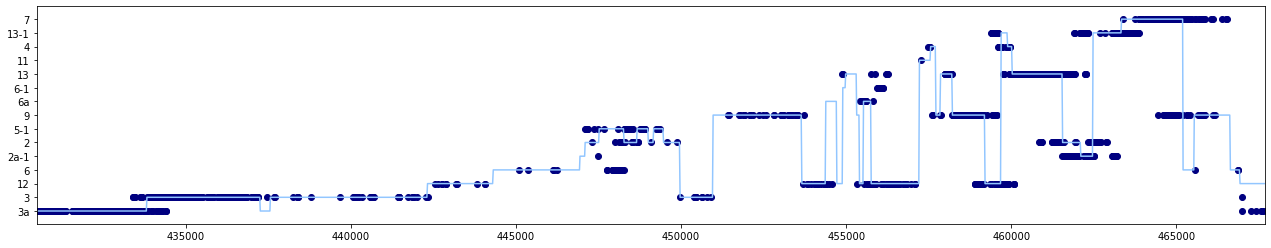

In [45]:
with plt.style.context(("seaborn-pastel",)):
    fig, ax = plt.subplots(1,1, figsize=(22,4))
    ax.plot(df.POINT_X, df.IGE)
    ax.scatter(df0.long, df0.IGE, c='navy')
    plt.xlim(df.POINT_X.min(), df[df.progressiva<40000]['POINT_X'].max())

In [46]:
###  ATTENZIONE PER AVERE UNA BUONA CORRISPONDENZA KARST VS LITOGRAFIA PLOTTARE I KARST CHE SONO PROSSIMI AL TRACCIATO!!! 
#check 100 = True troppi pochi punti
# con check 500 si ha un buon compromesso tra distorsione data dalla distanza dall'asse e il numero di karst

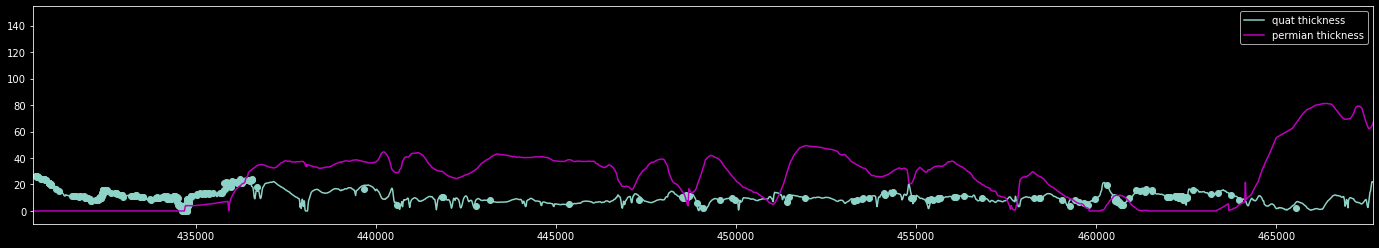

In [47]:
with plt.style.context(("dark_background",)):
    
    fig, ax = plt.subplots(1,1, figsize=(24,4))
    ax.plot(df.POINT_X, df.h_quat, label='quat thickness')
    ax.plot(df.POINT_X, df.h_perm, c='m', label='permian thickness')
    
    # se uso check  100 troppi pochi karst
    #ax.scatter(df0[df0.check_100 == True].long, df0[df0.check_100 == True].h_quat)
    #ax.scatter(df0.long, df0.h_quat)
    ax.scatter(df0[df0.check_500 == True].long, df0[df0.check_500 == True].h_quat)
    
    plt.legend()

    
    plt.xlim(df.POINT_X.min(), df[df.progressiva<40000]['POINT_X'].max())
    

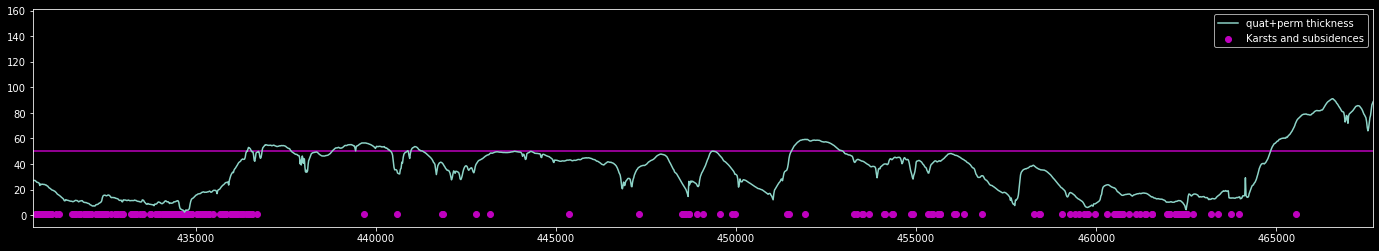

In [48]:
with plt.style.context(("dark_background",)):
    
    fig, ax = plt.subplots(1,1, figsize=(24,4))
    ax.plot(df.POINT_X, df.h_quat+df.h_perm, label='quat+perm thickness')
    ax.hlines(50,df.POINT_X.min(), df.POINT_X.max(), colors="m")
    
    #ax.scatter(df0.long, np.ones(df0.shape[0])*50, c="m", label="Karsts and subsidences")
    ax.scatter(df0[df0.check_500 == True].long, np.ones(df0[df0.check_500 == True].shape[0]), c="m", label="Karsts and subsidences")
    
    plt.legend()

    
    plt.xlim(df.POINT_X.min(), df[df.progressiva<40000]['POINT_X'].max())

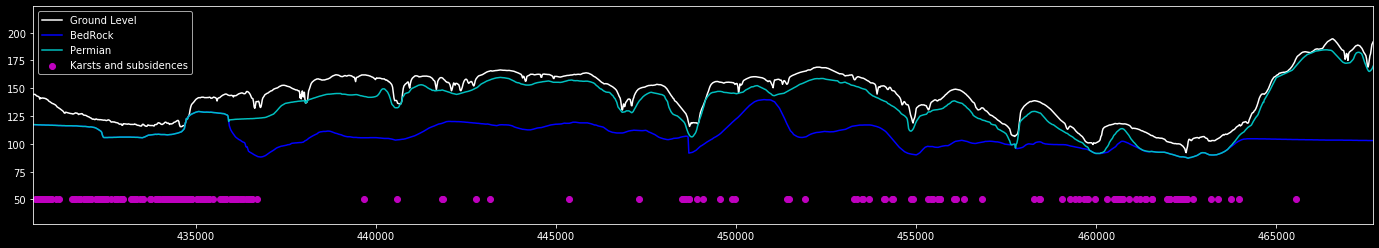

In [49]:
with plt.style.context(("dark_background",)):
    
    fig, ax = plt.subplots(1,1, figsize=(24,4))
    ax.plot(df.POINT_X, df_orig.m_s_l_m_, c="w", label="Ground Level")
    ax.plot(df.POINT_X, df_orig.calc_top, c="b", label="BedRock")
    ax.plot(df.POINT_X, df_orig.Arg_perm, c="c", label="Permian")

    #ax.scatter(df0.long, np.ones(df0.shape[0])*50, c="m", label="Karsts and subsidences")
    ax.scatter(df0[df0.check_500 == True].long, np.ones(df0[df0.check_500 == True].shape[0])*50, c="m", label="Karsts and subsidences")
    
    
    plt.legend()

    
    plt.xlim(df.POINT_X.min(), df[df.progressiva<40000]['POINT_X'].max())


### Calcolo Karst alla base con formula inversa

In [50]:
df0.columns

Index(['Unnamed: 0', 'ref', 'n_occ', 'long', 'lat', 'type', 'type2', 'type3',
       'dmax', 'dmin', 'dave', 'h', 'h/d', 'area', 'volume', 'era', 'fonte',
       'sector2000_50', 'check_100', 'check_500', 'sector2000_50_str',
       'h_perm', 'h_quat', 'IGE', 'vol_dave'],
      dtype='object')

#### Creo un dataframe con le proprietà meccaniche

In [51]:
df_prop = pd.read_csv('df_prop.csv', sep=';', index_col=0)

cols = df_prop.columns
df_prop[cols] = df_prop[cols].apply(pd.to_numeric, errors='ignore', downcast = 'float')

df_prop_rock = pd.read_csv('df_prop_rock.csv', index_col=0)

cols = df_prop_rock.columns
df_prop_rock[cols] = df_prop_rock[cols].apply(pd.to_numeric, errors='coerce', downcast = 'float')

df_prop

,lithotipo,gamma,gamma_stdev,gamma_MIN,gamma_MAX,e,e_stdev,e_MIN,e_MAX,"e,cr",IP,IP_stdev,IP_MIN,IP_MAX,IL,IL_stdev,IL_MIN,IL_MAX,Sr,Sr_stdev,Sr_MIN,Sr_MAX,E,E_stdev,E_MIN,E_MAX,nu,phi,phi_stdev,phi_MIN,phi_MAX,c,c_stdev,c_MIN,c_MAX,Dfis,Dfis_stdev,Dfis_MIN,Dfis_MAX
IGE_princi,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,a,20.190001,0.00,NaN,NaN,0.680,0.000,n.a,n.a,0.850,16.9,0.8,16.200001,19.000000,0.45,0.030,0.400,0.490,0.45,0,NaN,NaN,20.0,0.00,NaN,NaN,0.35,21.0,-,18.000000,24.000000,21.000000,-,16.0,26.000000,0.1,---,0.1,0.1
3a,s,25.969999,0.00,NaN,NaN,0.650,0.000,n.a,n.a,0.488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,---,---,NaN,NaN,30.0,0.00,NaN,NaN,0.25,35.0,-,32.000000,38.000000,21.000000,-,16.0,26.000000,0.0,0,0.0,0.1
12,a,19.110001,0.35,18.520000,19.700001,0.750,0.061,0.675,0.862,0.938,14.0,2.8,7.000000,18.900000,0.34,0.100,0.040,0.490,0.92,0.039,0.860,0.990,10.1,3.20,5.670000,14.820000,0.35,20.0,2.6,17.000000,23.000000,19.000000,5,9.0,24.000000,0.0,0,0.0,0.1
6,a,19.209999,0.39,18.330000,19.990000,0.740,0.080,0.6,0.9,0.925,10.5,2.0,8.000000,16.000000,0.58,0.090,0.400,0.730,0.93,0.03,0.870,0.980,9.0,1.96,5.800000,12.760000,0.35,14.0,3.2,9.000000,20.000000,18.000000,-,10.0,30.000000,0.0,NaN,0.0,0.1
2a-1,a,19.500000,0.66,18.910000,20.190001,0.680,0.079,0.604,0.787,0.850,12.2,3.1,9.700000,15.700000,0.63,0.120,0.503,0.741,0.94,0.1,0.809,1.046,4.0,0.46,3.500000,4.400000,0.35,20.0,1.8,18.299999,21.799999,27.799999,3.8,24.0,31.700001,0.1,NaN,0.3,0.1
5-1,s,18.420000,0.59,17.740000,19.110001,0.600,0.070,0.515,0.664,0.450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.57,0.26,0.180,0.806,20.0,0.00,NaN,NaN,0.25,29.0,-,26.000000,32.000000,1.000000,-,1.0,6.000000,0.0,0,0.0,0.1
2,a,19.110001,0.59,18.520000,20.190001,0.773,0.107,0.59,0.873,0.966,12.0,1.9,9.400000,16.299999,0.46,0.150,0.180,0.740,0.94,0.031,0.890,0.980,17.9,5.17,14.280000,21.600000,0.35,22.0,2.8,20.000000,24.000000,25.000000,10,18.0,32.000000,0.0,0,0.0,0.1
9,a,19.600000,0.57,18.910000,20.780001,0.659,0.083,0.497,0.738,0.824,10.0,1.0,0.080000,0.120000,0.19,0.130,0.020,0.440,0.92,0.062,0.840,0.990,15.8,8.60,9.750000,28.500000,0.35,22.0,3.3,18.000000,26.000000,27.000000,7,18.0,33.000000,0.0,NaN,0.0,0.0
6a,a,19.400000,0.00,NaN,NaN,0.750,0.000,n.a,n.a,0.938,14.4,NaN,NaN,NaN,0.59,NaN,NaN,NaN,0.93,0.03,NaN,NaN,12.0,0.00,NaN,NaN,0.35,18.0,-,15.000000,21.000000,20.000000,-,15.0,25.000000,0.0,0,0.0,0.1


#### FUNZIONE PER IL CALCOLO INVERSO

In [52]:
def calculate_dia(row, t, df_prop, df_prop_rock):
    
    # il diametro iniziale "d0" = 0.1 incrementato per step
    # when doing back calculation use t= 0
    
    lista_argille = df_prop[df_prop.lithotipo == 'a'].index.tolist()
    lista_sabbie = df_prop[df_prop.lithotipo == 's'].index.tolist()
    
    if row.h_perm>0:
        # TODO chiedere a Walter il permiano a che unità corrisponde
        # 14 --> J3 -->  "Clay grayish-brown, dusty, light, hard, J3
        list_layer = ['14']
        list_lathick = [row.h_perm]
    else:
        list_layer = []
        list_lathick  =[]

    if row.h_quat < 5:
        list_layer.append(row.IGE)
        list_lathick.append(row.h_quat)
    else:
        # se la litologia principale è argilla
        if df_prop.loc[row.IGE, 'lithotipo'] == 'a':
            # DO IT
            # crea una funzione che interpone un litotipo in sabbia
            # di spessore random uniform da 1/10 a 1/5 dello spessore totale dell'argilla
            list_layer.append(row.IGE)
            list_layer.append(random.choice(lista_sabbie))
            list_layer.append(row.IGE)
            randthick = random.uniform(row.h_quat/10, row.h_quat/5)
            list_lathick.append((row.h_quat - randthick)/2)
            list_lathick.append(randthick)
            list_lathick.append((row.h_quat - randthick)/2)
        else:  
            # se la litologia principale è sabbia
            # DO IT
            # crea una funzione che interpone un litotipo in argilla
            # di spessore random uniform da 1/10 a 1/5 dello spessore totale della sabbia  
            list_layer.append(row.IGE)
            list_layer.append(random.choice(lista_argille))
            list_layer.append(row.IGE)
            randthick = random.uniform(row.h_quat/10, row.h_quat/5)
            list_lathick.append((row.h_quat - randthick)/2)
            list_lathick.append(randthick)
            list_lathick.append((row.h_quat - randthick)/2)
  
    #print(list_layer, list_lathick, df_prop.lithotipo[list_layer].tolist())
    
    # a questo punto ho la lista con litotipi e spessori
    # per le rocce usa solo calcari ma tieni in conto una futura revisione
    
    d_0 = 0.33
    d_target = row.dave
    sv = 0   # sigma inizializzata a zero
    
    # per la versione a ritroso d0 =0.1 e incrementato di 0.1 fin quando al top dello strato non si trova
    # lo stesso valore di dave

    
    #=================================================   inizio calcdia_strato   =================================================
    
    def calcdia_strato(df_prop, d_pod, layer_i, thick_i, sv):
        # creare una funzione che restituisce il diametro strato superiore        
        # return i parametri che si aggiornano: d_top e sv 
        
        primoloop = True if sv == 0 else False
        
        radphi = np.radians(df_prop.phi[layer_i])
        _gamma = df_prop.gamma[layer_i]
        
        z1 = d_pod/2 * (1+2*np.sin(radphi))/(2*np.tan(radphi)*np.sin(radphi))
        
        x_2 = d_pod/2 * (1 + np.sin(radphi))**2/(4*np.sin(radphi)**3)
        X_2 = x_2 * 2
        
        z2 = z1 + d_pod/2*(1+np.sin(radphi))/(4*np.tan(radphi)*np.sin(radphi)**2)

        z3 = z2 + x_2/(np.tan(radphi))

        
        
        zone = 1 if(thick_i < z2) else (2 if thick_i < z3 else 3)   
        
        
        sv = sv + df_prop.gamma[layer_i] * thick_i
            
        eta = 0
       
        if df_prop.lithotipo[layer_i] == 'a':
            
            '''
            ********* ARGILLE  *******
            '''
                  
            _IL = float(df_prop.IL[layer_i])
            _c = df_prop.c[layer_i]
            if _c == 0: _c = 1
            _dfis = df_prop.Dfis[layer_i]
            

            dcrit = 2 * thick_i * ((np.tan(np.pi/4-radphi/2))**2 * np.tan(radphi) + 2 *_c * (1 - _IL)/sv)
            if dcrit < 0.01: dcrit = 0.01
            dpipe = np.exp(_IL) * _dfis * _gamma * thick_i / _c
            
            # parametro per il calcolo Pds
            eta = thick_i * dpipe / dcrit
            
            ## primo loop
            
            d_top = d_pod
            
            if (not primoloop) and (d_pod > dpipe): 
                if d_pod > dcrit:
                    d_top = dcrit
                else:
                    d_top = dpipe
            else:
                #d_top = d_pod   ********** ATTENZIONE ************
                d_top = d_pod
                pass
        
        else:
            '''
            *********  SABBIE   *******
            '''
            
            if zone == 1 :
                d_top = (X_2 - d_pod) / z2 * thick_i + d_pod
                #print('zone1 :',zone,'z2',z2,'z3',z3,'dpod: ',d_pod, 'phi: ', df_prop.phi[layer_i], 'radphi: ', radphi, 'gamma: ', _gamma)
            elif zone == 2 :
                d_top = X_2
                #print('zone2 :',zone,'z2',z2,'z3',z3,'dpod: ',d_pod, 'phi: ', df_prop.phi[layer_i], 'radphi: ', radphi, 'gamma: ', _gamma)
            else :
                #d_top = 0    ********** ATTENZIONE ************
                d_top = X_2
                #print('zone3 :',zone,'z2',z2,'z3',z3,'dpod: ',d_pod, 'phi: ', df_prop.phi[layer_i], 'radphi: ', radphi, 'gamma: ', _gamma)
        
        vol = np.pi * thick_i / 3 * (d_pod**2 / 4 + d_pod * d_top / 4 + d_top**2 / 4)
        
        if zone == 3: vol = vol + np.pi * d_pod**2 * (thick_i - z3) / 4
            
        e_i = float(df_prop.e[layer_i])
        ecr_i = float(df_prop["e,cr"][layer_i])
            
        deltav = (ecr_i - e_i) /(1 + ecr_i) * vol
        
        return d_top, sv, vol, eta
    
    #===========================================  end calcdia_strato      ============================================================  
    
    
    
    
    
    
    
    #================================================================================================================================        
        
    def calc_fixed_par(t, df_prop_rock, d_0, list_layer):
        
        # when doing back calculation use t=0
        
        v_r = df_prop_rock.v_r.Calcari
        h_p = d_0/2.5  # da controllare
        D1 = v_r * t + d_0
        m_k = df_prop_rock.m_k.Calcari
        k_k = df_prop_rock.k_k.Calcari
        phiradmedio = df_prop.phi[list_layer].mean()

        return(v_r, h_p, D1, m_k, k_k, phiradmedio)
    
    #===========================================   end  calc_fixed_par       =======================================================  
    
    
    v_r, h_p, d_0, m_k, k_k, phiradmedio  = calc_fixed_par(t, df_prop_rock, d_0, list_layer)  
    
    
    
    
    
    
    
    
    
    
    #===========================================   inizio ciclo iterativo       =======================================================
    step = 1
    
    while True:
        
        d_top = d_0
           
        list_dia = [d_0] # il primo della lista è il d_pod
        list_vol = []
        list_eta = []
        
        for i, e in enumerate(list_layer):
            # calcola per tutti i layer quando esce dal loop d_0 = diam al piano campagna
            layer_i = e
            thick_i = list_lathick[i]
            
            d_top, sv, vol, eta = calcdia_strato(df_prop, d_top, layer_i, thick_i, sv)
            
            list_dia.append(d_top)
            list_vol.append(vol)
            list_eta.append(eta)
            
        # d_0 è il d alla base
        # d_top è quello calcolato a piano campagna
        
        if d_top < d_target:
            step += 1
            d_0 += 0.33
            
            # ricomincia il loop da while con il valore d_0 incrementato
            if step == 100: 
                d_0 = d_target
                #print('Risultato finale max iteration: ', d_0, d_top, list_dia)
                break
            else:
                pass
                
        else:
            # esci dal loop il primo valore d_0 che porta d_top > d_target è quello finale
            #print('Risultato finale : ', d_0, d_top, list_dia)
            break
    
    
    #===========================================   fine ciclo iterativo       =======================================================
    
    
    
    
    
    
    
    
    #===========================================    inizio calcprob         =========================================================    
    
    def calc_prob(df_prop, df_prop_rock, list_layer, d_top, v_r, h_p, D1, m_k, k_k, phiradmedio, t, list_vol, list_eta):

        # H_k = non richiesta
        
        Va_0 = np.pi * D1**2 * h_p/4
        
        Va_1 = np.pi * m_k * (k_k + v_r * t / m_k) * (3*D1**2 + ( 2 * m_k * (3*D1 + \
                2 * m_k / np.tan(phiradmedio)) / (np.tan(phiradmedio))))/12

        Va = Va_0 + Va_1
        
        list_Va0i = list_vol + Va_0
        
        sum_Va0i = np.array(list_Va0i).sum()
        sum_eta = np.array(list_eta).sum()
        sum_m = np.array(list_lathick).sum()

        Pds = 1 - np.exp(-Va / sum_Va0i * sum_eta / sum_m)

        return Pds
    
    #===========================================     fine  calcprob         ========================================================= 

    
    
    
    

    # Nel calcolo non a ritroso se Pds < 0.3 --> d_0 = 0
    #Pds = calc_prob(df_prop, df_prop_rock, list_layer, d_top, v_r, h_p, D1, m_k, k_k, phiradmedio, t, list_vol, list_eta)
    
    if (row.h_perm == 0) & (row.h_quat == 0) : d_0 = d_target
    
    #print("\n", "===========================================================================================================", "\n")
    
    return d_0



In [53]:
df0['dbase'] = df0.apply(calculate_dia, axis=1, args=(0, df_prop, df_prop_rock))

## DA QUI INIZIANO LE 1000 SIMULAZIONI

- n_karst_soglia confermato = 70 (totale giovani + antichi)
- ritorno a considerare solo quelli giovani
- confermo : permiano > 40m d_top = 0
- confermo : permiano + quat > 50m d_top = 0
- la funzione calcola strato return d_top e Pds
- creo prima il df_zo poi seleziono il check100 per creare df_zo_100


### TROVA DISTRIBUZIONE PER OGNI ZONA E CREA STOCH

In [54]:
def trova_distr_exp(df_g50, hh = 'none'):

    # cerco l'area con più karst
    # e quella con karst minimo (il minimo viene definito qui)
    n_karst_soglia = 70
    # numero max
    n_max_settore = int(df_g50.n_karst.max())
    # settore con numero max
    settore_nmax= df_g50[df_g50.n_karst == df_g50.n_karst.max()].sector2000_50.tolist()[0]
    # settore con numero karst basso ma maggiore di 5:
    settore_nmin= df_g50[df_g50.n_karst >= n_karst_soglia].sort_values("n_karst").sector2000_50.tolist()[0]
    
    # se non metto nulla negli attributi della dex usa il max
    if hh  == 'none':
        h = settore_nmax
        
    elif df_g50[df_g50.sector2000_50==hh].n_karst.tolist()[0] < n_karst_soglia:
        h = settore_nmin
        
    else:
        h = hh

    zo_dave = df0[(df0.sector2000_50==h)&(df0.era == "Giovane")].dbase
    # per aumentare la stima del numero considero anche quelli antichi
    #zo_dave = df0[df0.sector2000_50==h].dbase

    # TO DO TRY WITH st.truncexp
    params = st.expon.fit(zo_dave, floc=0)

    scale = params[1]/2

    zo_perc5 = int(np.percentile(zo_dave, 5))
    zo_perc95 = int(np.percentile(zo_dave, 95))
    zo_karstnum = zo_dave.shape[0]

    zo_perc5, zo_perc95, zo_karstnum

    # calcolo le proporzioni tra i karst sotto il 5p
    # 1. zo_karstnum_simul è il numero su 1000 dei karst individuati a rilievo
    # 2. zo_nbelow5p_simul è la stima su 1000 dei karst non individuati
    # zo_tot è il totale della popolazione (tolto il frattile superiore al 95% che viene considerato un errore)
    # zo_tot_prop è la proporzione tra il totale della simulazione e 1+2
    # zo_pop_prop è la proporzione tra il totale della popolazione (compreso frattile >95%) e 1+2

    size = 1000
    r = expon.rvs(scale=scale, size=size)

    zo_karstnum_simul = r[(zo_perc5<r)&(r<zo_perc95)].shape[0]
    zo_nbelow5p_simul = r[r<zo_perc5].shape[0]
    zo_tot = zo_karstnum_simul + zo_nbelow5p_simul
    zo_tot_prop = zo_tot/zo_karstnum_simul
    zo_pop_prop = size/zo_karstnum_simul

    zo_karstnum_simul, zo_nbelow5p_simul, zo_tot, zo_tot_prop, zo_pop_prop

    zo_nbelow5p = int(round(zo_karstnum/zo_karstnum_simul*zo_nbelow5p_simul,0))
    zo_nbelow5p

    # the number of data to obtain 27 karst less than 6m is
    # 37/538*1000




    zo_karstnum_pop = int(round(zo_karstnum/zo_karstnum_simul*r.shape[0],0))
    zo_karstnum_pop

    # zo_karstnum_pop = sono quelli totali della simulazione
    # zo_karstnum = sono quelli effettivi individuati 95p e non individuati)

    zo_karstnum_pop = int(round(zo_pop_prop *zo_karstnum, 0))
    
    return zo_nbelow5p, zo_karstnum_pop, zo_karstnum, settore_nmax, scale

### calcolo diametro per ogni strato

In [55]:
def calculate_dia_diretto(row, t, df_prop, df_prop_rock, stochastic = False):
    
    '''
    input:
    row del df_zo
    t = int(vita utile dell'opera serve per calcolare la dissoluzione e il dia finale)
    df_prop = dataframe con le proprietà per ogni IG
    df_prop_rock = dataframe con le proprietpà del substrato
    stochastic = False use deterministic values True use uniform distribution MIN-MAX
    return:
    d_top : float (diametro parte alta dello strato)
    
    versioni:
    1° deterministico, ogni d_0 crea un d_top, se Pds<30% in automatico d_top = 0
        se permiano e quat = 0 d_top = d_0
    2° prob usa MIN-MAX, d_top = 0 se h_perm > 40 o se h_perm+h_quat >50
        
    
    
    '''
    
    d_0 = row.dave
    
    lista_argille = df_prop[df_prop.lithotipo == 'a'].index.tolist()
    lista_sabbie = df_prop[df_prop.lithotipo == 's'].index.tolist()
    
    if ((row.h_perm == 0) & (row.h_quat == 0)) : 
        d_top = d_0
        Pds = 1
    elif row.h_perm > 40:
        d_top = 0
        Pds = 0
    elif ((row.h_perm + row.h_quat) > 50):
        d_top = 0
        Pds = 0
    else:

        if row.h_perm > 0:
            # TODO chiedere a Walter il permiano a che unità corrisponde
            # 14 --> J3 -->  "Clay grayish-brown, dusty, light, hard, J3
            list_layer = ['17']
            list_lathick = [row.h_perm]
        else:
            list_layer = []
            list_lathick  =[]

        if row.h_quat < 5:
            list_layer.append(row.IGE)
            list_lathick.append(row.h_quat)
        else:
            # se la litologia principale è argilla
            if df_prop.loc[row.IGE, 'lithotipo'] == 'a':
                # DO IT
                # crea una funzione che interpone un litotipo in sabbia
                # di spessore random uniform da 1/10 a 1/5 dello spessore totale dell'argilla
                list_layer.append(row.IGE)
                list_layer.append(random.choice(lista_sabbie))
                list_layer.append(row.IGE)
                randthick = random.uniform(row.h_quat/10, row.h_quat/5)
                list_lathick.append((row.h_quat - randthick)/2)
                list_lathick.append(randthick)
                list_lathick.append((row.h_quat - randthick)/2)
            else:  
                # se la litologia principale è sabbia
                # DO IT
                # crea una funzione che interpone un litotipo in argilla
                # di spessore random uniform da 1/10 a 1/5 dello spessore totale della sabbia  
                list_layer.append(row.IGE)
                list_layer.append(random.choice(lista_argille))
                list_layer.append(row.IGE)
                randthick = random.uniform(row.h_quat/10, row.h_quat/5)
                list_lathick.append((row.h_quat - randthick)/2)
                list_lathick.append(randthick)
                list_lathick.append((row.h_quat - randthick)/2)

        ##print(list_layer, list_lathick, df_prop.lithotipo[list_layer].tolist())

        # a questo punto ho la lista con litotipi e spessori
        # per le rocce usa solo calcari ma tieni in conto una futura revisione

        
        sv = 0   # sigma inizializzata a zero



        #=================================================   inizio calcdia_strato   =================================================

        def calcdia_strato(df_prop, d_pod, layer_i, thick_i, sv):
            # creare una funzione che restituisce il diametro strato superiore        
            # return i parametri che si aggiornano: d_top e sv 

            primoloop = True if sv == 0 else False
            
            _phi = df_prop.phi[layer_i]
            if stochastic: _phi = random.uniform(df_prop.phi_MIN[layer_i], df_prop.phi_MAX[layer_i])  
            radphi = np.radians(_phi)
            
            _gamma = df_prop.gamma[layer_i]

            z1 = d_pod/2 * (1+2*np.sin(radphi))/(2*np.tan(radphi)*np.sin(radphi))

            x_2 = d_pod/2 * (1 + np.sin(radphi))**2/(4*np.sin(radphi)**3)
            X_2 = x_2 * 2

            z2 = z1 + d_pod/2*(1+np.sin(radphi))/(4*np.tan(radphi)*np.sin(radphi)**2)

            z3 = z2 + x_2/(np.tan(radphi))



            zone = 1 if(thick_i < z2) else (2 if thick_i < z3 else 3)   


            sv = sv + df_prop.gamma[layer_i] * thick_i

            eta = 0

            if df_prop.lithotipo[layer_i] == 'a':

                '''
                ********* ARGILLE  *******
                '''

                _IL = float(df_prop.IL[layer_i])
                
                
                _c = df_prop.c[layer_i]              
                if stochastic: _c = random.uniform(df_prop.c_MIN[layer_i], df_prop.c_MAX[layer_i])
                if _c == 0: _c = 1
                    
                    
                _dfis = df_prop.Dfis[layer_i]
                if stochastic: _dfis = random.uniform(df_prop.Dfis_MIN[layer_i], df_prop.Dfis_MAX[layer_i])


                dcrit = 2 * thick_i * ((np.tan(np.pi/4-radphi/2))**2 * np.tan(radphi) + 2 *_c * (1 - _IL)/sv)
                if dcrit < 0.01: dcrit = 0.01
                dpipe = np.exp(_IL) * _dfis * _gamma * thick_i / _c

                # parametro per il calcolo Pds
                eta = thick_i * dpipe / dcrit

                ## primo loop

                d_top = d_pod

                if (not primoloop) and (d_pod > dpipe): 
                    if d_pod > dcrit:
                        d_top = dcrit
                    else:
                        d_top = dpipe
                else:
                    #d_top = d_pod   ********** ATTENZIONE ************
                    d_top = d_pod
                    pass

            else:
                '''
                *********  SABBIE   *******
                '''

                if zone == 1 :
                    d_top = (X_2 - d_pod) / z2 * thick_i + d_pod
                    ##print('zone1 :',zone,'z2',z2,'z3',z3,'dpod: ',d_pod, 'phi: ', df_prop.phi[layer_i], 'radphi: ', radphi, 'gamma: ', _gamma)
                elif zone == 2 :
                    d_top = X_2
                    ##print('zone2 :',zone,'z2',z2,'z3',z3,'dpod: ',d_pod, 'phi: ', df_prop.phi[layer_i], 'radphi: ', radphi, 'gamma: ', _gamma)
#                 elif thick_i > (z3*3):
#                     #print("thick_i > (z3*3)")
#                     d_top = 0
                else :
                    #d_top = 0    ********** ATTENZIONE ************
                    d_top = X_2
                    ##print('zone3 :',zone,'z2',z2,'z3',z3,'dpod: ',d_pod, 'phi: ', df_prop.phi[layer_i], 'radphi: ', radphi, 'gamma: ', _gamma)

            vol = np.pi * thick_i / 3 * (d_pod**2 / 4 + d_pod * d_top / 4 + d_top**2 / 4)

            if zone == 3: vol = vol + np.pi * d_pod**2 * (thick_i - z3) / 4

            e_i = float(df_prop.e[layer_i])
            ecr_i = float(df_prop["e,cr"][layer_i])

            deltav = (ecr_i - e_i) /(1 + ecr_i) * vol

            return d_top, sv, vol, eta

        #===========================================  end calcdia_strato      ============================================================  







        #================================================================================================================================        

        def calc_fixed_par(t, df_prop_rock, d_0, list_layer):

            # when doing back calculation use t=0

            v_r = df_prop_rock.v_r.Calcari
            h_p = d_0/2.5  # da controllare
            D1 = v_r * t + d_0
            m_k = df_prop_rock.m_k.Calcari
            k_k = df_prop_rock.k_k.Calcari
            phiradmedio = df_prop.phi[list_layer].mean()

            return(v_r, h_p, D1, m_k, k_k, phiradmedio)

        #===========================================   end  calc_fixed_par       =======================================================  


        # sovrascrivo d_0 a quello originale in teoria dovrebbe chiamarsi D1 ovverso il diametro d_0 allargato con dissoluzione a t anni

        v_r, h_p, d_0, m_k, k_k, phiradmedio  = calc_fixed_par(t, df_prop_rock, d_0, list_layer)  










        #===========================================   inizio calcolo       =======================================================


        d_top = d_0

        list_dia = [d_0] # il primo della lista è il d_pod
        list_vol = []
        list_eta = []

        for i, e in enumerate(list_layer):
            # calcola per tutti i layer quando esce dal loop d_0 = diam al piano campagna
            layer_i = e
            thick_i = list_lathick[i]

            d_top, sv, vol, eta = calcdia_strato(df_prop, d_top, layer_i, thick_i, sv)

            list_dia.append(d_top)
            list_vol.append(vol)
            list_eta.append(eta)

        # d_0 è il d alla base (INPUT)
        # d_top è quello calcolato a piano campagna (OUTPUT)


        #===========================================   fine ciclo iterativo       =======================================================








        #===========================================    inizio calcprob         =========================================================    

        def calc_prob(df_prop, df_prop_rock, list_layer, d_top, v_r, h_p, D1, m_k, k_k, phiradmedio, t, list_vol, list_eta):

            # H_k = non richiesta

            Va_0 = np.pi * D1**2 * h_p/4

            Va_1 = np.pi * m_k * (k_k + v_r * t / m_k) * (3*D1**2 + ( 2 * m_k * (3*D1 + \
                    2 * m_k / np.tan(phiradmedio)) / (np.tan(phiradmedio))))/12

            Va = Va_0 + Va_1

            list_Va0i = list_vol + Va_0

            sum_Va0i = np.array(list_Va0i).sum()
            sum_eta = np.array(list_eta).sum()
            sum_m = np.array(list_lathick).sum()

            Pds = 1 - np.exp(-Va / sum_Va0i * sum_eta / sum_m)

            return Pds

        #===========================================     fine  calcprob         ========================================================= 





        # Aggiungere che se la Pds < 0.3 si forma una sinclinale con diametro da calcolare

        Pds = calc_prob(df_prop, df_prop_rock, list_layer, d_top, v_r, h_p, d_0, m_k, k_k, phiradmedio, t, list_vol, list_eta)
        #print("Pds is :", Pds, "d_top is: ", d_top)
        
        #  IL CALCOLO IN FUNZIONE DI PDS LO FACCIO MANUALMENTE DOPO
        #         if ((Pds < 0.1) & (row.h_perm <20)): 
        #             d_top = 0
        #             #print('(Pds < 0.3) & (row.h_perm <20)')
        #         elif ((Pds < 0.3) & (row.h_perm >=20)):
        #             d_top = 0
        #             #print('(Pds < 0.5) & (row.h_perm >20)')
        #         else:
        #             pass
            

    
    ##print("\n", "===========================================================================================================", "\n")

    return pd.Series([d_top, Pds])


### CREO UN QUADRATO GRANDE ATTORNO ALL'AREA

In [56]:
def create_df_zo(df_g50, h, zo_nbelow5p, zo_karstnum, zo_karstnum_pop, df_pred, scale):
    # per i diametri
    # devo fare una distribuzione con 68 elementi e inserire solo i primi 
    # 27 elementi ordinati per grandezza

    xmin = min(df_g50.loc[df_g50.index[h],'vtrackdown2000x'],
                               df_g50.loc[df_g50.index[h+1],'vtrackdown2000x'],
                               df_g50.loc[df_g50.index[h],'vtrackup2000x'],
                               df_g50.loc[df_g50.index[h+1],'vtrackup2000x']
                              )
    xmax = max(df_g50.loc[df_g50.index[h],'vtrackdown2000x'],
                               df_g50.loc[df_g50.index[h+1],'vtrackdown2000x'],
                               df_g50.loc[df_g50.index[h],'vtrackup2000x'],
                               df_g50.loc[df_g50.index[h+1],'vtrackup2000x']
                              )
    ymin = min(df_g50.loc[df_g50.index[h],'vtrackdown2000y'],
                               df_g50.loc[df_g50.index[h+1],'vtrackdown2000y'],
                               df_g50.loc[df_g50.index[h],'vtrackup2000y'],
                               df_g50.loc[df_g50.index[h+1],'vtrackup2000y']
                              )
    ymax = max(df_g50.loc[df_g50.index[h],'vtrackdown2000y'],
                               df_g50.loc[df_g50.index[h+1],'vtrackdown2000y'],
                               df_g50.loc[df_g50.index[h],'vtrackup2000y'],
                               df_g50.loc[df_g50.index[h+1],'vtrackup2000y']
                              )
    area_gr = (xmax-xmin)*(ymax-ymin)/1e6
    n_karst_5p_areag = int(round(zo_nbelow5p/df_g50.sector_area[h]*area_gr,0))
    # 5p + visiblekarst
    n_karst_areag = int(round(zo_nbelow5p + zo_karstnum / df_g50.sector_area[h] * area_gr,0))
    # 5p + visiblekarst + outofsize
    zo_karstnum_pop_areag = int(round(zo_karstnum_pop / df_g50.sector_area[h] * area_gr,0))

    # n_karst_5p_areag, n_karst_areag, zo_karstnum_pop_areag

    stoch_karstx = np.random.uniform(xmin, xmax, n_karst_areag)
    stoch_karsty = np.random.uniform(ymin, ymax, n_karst_areag)
    # creo the full curve in the areagrande areag estraggo i primi n-karst-5p-areag valori
    stoch_karstdia = expon.rvs(scale=scale, size=zo_karstnum_pop_areag)
    stoch_karstdia.sort()
    stoch_karstdia = stoch_karstdia[:n_karst_areag]

    #### creo l'array con tutti i karst sotchastici nell'area grande

    zo_arr = np.vstack([stoch_karstx, stoch_karsty, stoch_karstdia]).T

    #### Rimuovo i karst fuori dall'area di settore

    def abs_sum(row, i):
        check = False
        polygon = Polygon([tuple(df_g50[['vtrackup2000x','vtrackup2000y']].loc[i,:]),
                      tuple(df_g50[['vtrackup2000x','vtrackup2000y']].loc[i+1,:]),
                      tuple(df_g50[['vtrackdown2000x','vtrackdown2000y']].loc[i+1,:]),
                      tuple(df_g50[['vtrackdown2000x','vtrackdown2000y']].loc[i,:])])

        point = Point(row[0], row[1])

        if polygon.contains(point): check = True

        return check

    zo_arr = np.vstack([zo_arr.T, np.apply_along_axis(abs_sum, 1, zo_arr, h)]).T
    zo_arr = zo_arr[zo_arr[:,3]==True][:,:3]
    df_zo = pd.DataFrame(zo_arr, columns=['long','lat','dave'])
    # rinomino le colonne 
    # zo_arr = np.vstack([stoch_karstx, stoch_karsty, stoch_karstdia])
    # "dave" qui è il d alla base attenzione ho invertito nel df0 dave è al piano campagna

    df_zo['sector2000_50'] = int(h)           # per associazione con df0 e df_g50
    df_zo['sector2000_50_str'] = str(h)     # per associazione con df0
    
    points = df_pred.loc[:,['POINT_X','POINT_Y']]
    values_h_perm = df_pred.loc[:,['h_perm']]
    values_h_quat = df_pred.loc[:,['h_quat']]
    values_ige = df_pred.loc[:,['IGE']]
    values_tipo = df_pred.loc[:,['Tipo']]
    values_h_rilevato = df_pred.loc[:,['h_rilevato']]

    point_pred = df_zo.loc[:,['long','lat']]
    df_zo['h_perm'] = predict(points, values_h_perm, point_pred)
    df_zo['h_quat'] = predict(points, values_h_quat, point_pred)
    df_zo['IGE'] = predict(points, values_ige, point_pred)
    df_zo['Tipo'] = predict(points, values_tipo, point_pred)
    df_zo['h_rilevato'] = predict(points, values_h_rilevato, point_pred)
    


    #### Calcolo diametro in superficie
    
    df_zo[['dbase','Pds']] = df_zo.apply(calculate_dia_diretto, axis=1, args=(100, df_prop, df_prop_rock))
    df_zo['dbase'] = df_zo['dbase'].astype('float', errors='ignore')
    
    def create_df_zo_100(row, df_g50, df_zo):

        for i in range(df_g50.shape[0]-1):

            check = False

            polygon = Polygon([tuple(df_g50[['vtrackupx','vtrackupy']].loc[i,:]),
                          tuple(df_g50[['vtrackupx','vtrackupy']].loc[i+1,:]),
                          tuple(df_g50[['vtrackdownx','vtrackdowny']].loc[i+1,:]),
                          tuple(df_g50[['vtrackdownx','vtrackdowny']].loc[i,:])])

            point = Point(row['long'], row['lat'])

            if polygon.contains(point): 
                check = True        
                break
            else:
                pass

        return check
    
    df_zo['check_100'] = df_zo.apply(create_df_zo_100, axis=1, args = (df_g50, df_zo))
    
    return df_zo



#### Applico la def "create_df_zo" per creare il dataframe con la colonna dbase --> il diametro in superficie  --> una sola iterazione stochastica
#### Risultati non utizzati

In [57]:
df_zo = pd.DataFrame(columns=['long', 'lat', 'dave', 'sector2000_50', 'sector2000_50_str', 'h_perm',
       'h_quat', 'IGE', 'dbase','Tipo','h_rilevato','check_100'])

#zo_nbelow5p, zo_karstnum_pop, zo_karstnum, settore_nmax, scale = trova_distr_exp(df_g50)


##109
for hh in range(2):
    
    zo_nbelow5p, zo_karstnum_pop, zo_karstnum, settore_nmax, scale = trova_distr_exp(df_g50, hh==hh)
    df_zo = df_zo.append(create_df_zo(df_g50, hh, zo_nbelow5p, zo_karstnum, zo_karstnum_pop, df_pred, scale), ignore_index=True, sort=True)
    
# associo le tipologie di dato corrette

df_zo['dbase'] = df_zo['dbase'].astype('float')
df_zo['sector2000_50'] = df_zo['sector2000_50'].astype('int')

In [58]:
df_zo[df_zo.dbase>0]

,IGE,Pds,Tipo,check_100,dave,dbase,h_perm,h_quat,h_rilevato,lat,long,sector2000_50,sector2000_50_str
0,3a,0.000000,Rilevato,False,0.193790,3.006812,0.0,21.280071,1.860024,6.152549e+06,430869.723398,0,0
1,3a,0.067690,Rilevato,False,0.251668,0.953656,0.0,26.258799,4.200000,6.150282e+06,430557.894777,0,0
2,3a,0.000000,Rilevato,False,0.540551,7.151643,0.0,17.587435,1.707853,6.153098e+06,431011.332860,0,0
3,3a,0.000000,Rilevato,False,0.543750,9.016732,0.0,24.260439,2.797807,6.149815e+06,430797.301025,0,0
4,3a,0.000000,Rilevato,False,0.646272,6.935272,0.0,11.423842,3.434877,6.152188e+06,431370.699934,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,3a,0.000000,Rilevato,False,10.380086,6.399842,0.0,8.595329,2.500000,6.151985e+06,432275.861940,1,1
62,3a,0.007468,Rilevato,True,11.208272,3.100963,0.0,10.005604,2.200000,6.151664e+06,432356.650265,1,1
63,3a,0.003157,Rilevato,False,12.057561,4.799865,0.0,11.399476,1.701047,6.149229e+06,431665.099711,1,1
64,3a,0.000000,Rilevato,True,13.933524,5.080705,0.0,7.363639,2.736361,6.151664e+06,432177.546604,1,1


## Creo file df_zo  con iterazioni stochastiche per mappe
## Creo file df_zo_100 ma con iterazioni stochastiche e solo nell'intorno 100m

####  Funzioni propedeutiche al calcolo

In [59]:
def rilevato_ksmall(row):
    
    if (row['Tipo'] == 'Rilevato') & (row['dbase'] < soglia_dia_karst):
        quantity = 1     
    else:
        quantity = 0
    return quantity


def rilevato_klarge(row):
    
    if (row['Tipo'] == 'Rilevato') & (row['dbase'] >= soglia_dia_karst): 
        quantity = 1
    else:
        quantity = 0    
    return quantity

def trincea_ksmall(row):
    
    if (row['Tipo'] == 'Trincea') & (row['dbase'] < soglia_dia_karst):
        quantity = 1     
    else:
        quantity = 0
    return quantity


def trincea_klarge(row):
    
    if (row['Tipo'] == 'Trincea') & (row['dbase'] >= soglia_dia_karst): 
        quantity = 1
    else:
        quantity = 0    
    return quantity


def vidotto_ksmall(row):
    
    if (row['Tipo'] != 'Rilevato') & (row['Tipo'] != 'Trincea') & (row['dbase'] < soglia_dia_karst) & (row['h_rilevato'] > lim_via_bridge):        
        quantity = 1        
    else:        
        quantity = 0        
    return quantity


def vidotto_klarge(row):
    
    if (row['Tipo'] != 'Rilevato') & (row['Tipo'] != 'Trincea') & (row['dbase'] >= soglia_dia_karst) & (row['h_rilevato'] > lim_via_bridge):        
        quantity = 1        
    else:        
        quantity = 0        
    return quantity


def passaggio_ksmall(row):
    
    if (row['Tipo'] != 'Rilevato') & (row['Tipo'] != 'Trincea') & (row['dbase'] < soglia_dia_karst) & (row['h_rilevato'] <= lim_via_bridge):        
        quantity = 1        
    else:        
        quantity = 0        
    return quantity


def passaggio_klarge(row):
    
    if (row['Tipo'] != 'Rilevato') & (row['Tipo'] != 'Trincea') & (row['dbase'] >= soglia_dia_karst) & (row['h_rilevato'] <= lim_via_bridge):        
        quantity = 1        
    else:        
        quantity = 0        
    return quantity

#### INIZIO IL CALCOLO STOCHASTICO

In [ ]:
# inizializzo df_zo

df_zo = pd.DataFrame(columns=['long', 'lat', 'dave', 'sector2000_50', 'sector2000_50_str', 'h_perm',
       'h_quat', 'IGE', 'dbase', 'Tipo', 'h_rilevato', 'Pds', 'check_100', 'epoch'])

# se voglio una simulazione con la distribuzione spaziale più sfigata
#zo_nbelow5p, zo_karstnum_pop, zo_karstnum, settore_nmax, scale = trova_distr_exp(df_g50, hh='none')

#======================================================================================================

for epoch in trange(epochs, file=sys.stdout, desc='epoch advance'):
    
    for hh in range(pkfinale):
        
        zo_nbelow5p, zo_karstnum_pop, zo_karstnum, settore_nmax, scale = trova_distr_exp(df_g50, hh=hh)
        
        row_temp = create_df_zo(df_g50, hh, zo_nbelow5p, zo_karstnum, zo_karstnum_pop, df_pred, scale)
        row_temp['epoch'] = epoch
        
        # sort=True --> to avoid warning appearing
        df_zo = df_zo.append(row_temp, ignore_index=True, sort=False)
        
#======================================================================================================
    
# nel df_zo_100 devono rimanere i punti che stanno nella fascia 100m e che hanno dia > 0
df_zo_100 = df_zo[df_zo.check_100 == True]
df_zo_100 = df_zo_100[df_zo_100.dbase > 0]

# creo colonne per la definizione delle quantita di interventi
try:
    df_zo_100['ril_ksmall'] = df_zo_100.apply(rilevato_ksmall, axis=1)
    df_zo_100['ril_klarge'] = df_zo_100.apply(rilevato_klarge, axis=1)
    df_zo_100['tri_ksmall'] = df_zo_100.apply(trincea_ksmall, axis=1)
    df_zo_100['tri_klarge'] = df_zo_100.apply(trincea_klarge, axis=1)
    df_zo_100['via_ksmall'] = df_zo_100.apply(vidotto_ksmall, axis=1)
    df_zo_100['via_klarge'] = df_zo_100.apply(vidotto_klarge, axis=1)
    df_zo_100['pas_ksmall'] = df_zo_100.apply(passaggio_ksmall, axis=1)
    df_zo_100['pas_klarge'] = df_zo_100.apply(passaggio_klarge, axis=1)
except:
    pass

# area della semisfera

df_zo['vol_dave'] = 4/3*np.pi*(df_zo.dave/2)**3 / 2
df_zo_100['vol_dave'] = 4/3*np.pi*(df_zo_100.dave/2)**3 / 2

df_zo.fillna(0, inplace=True)
df_zo_100.fillna(0, inplace=True)

df_zo['h_copertura'] = df_zo.h_quat + df_zo.h_perm
df_zo_100['h_copertura'] = df_zo.h_quat + df_zo.h_perm
    
df_zo.to_csv('df_zo.csv', sep=';')
df_zo_100.to_csv('df_zo_100.csv', sep=';')
df.to_csv('df.csv', sep=';')
df0.to_csv('df0.csv', sep=';')
df.to_csv('df.csv', sep=';')
df_g50.to_csv('df_g50.csv', sep=';')

epoch advance:  69%|██████████████████████████████████████████                   | 69/100 [8:55:15<4:09:38, 483.19s/it]


## ===================================================================================

#### MAKE df0 similar to df_zo mancano check_100

In [ ]:
point_pred = df0.loc[:,['long','lat']]
df0['h_perm'] = predict(points, values_h_perm, point_pred)
df0['h_quat'] = predict(points, values_h_quat, point_pred)
df0['IGE'] = predict(points, values_ige, point_pred)
df0['Tipo'] = predict(points, values_tipo, point_pred)
df0['h_rilevato'] = predict(points, values_h_rilevato, point_pred)

In [ ]:
df0_100 = df0[df0.check_100==True]

In [ ]:
try:
    df0_100['ril_ksmall'] = df0_100.apply(rilevato_ksmall, axis=1)
    df0_100['ril_klarge'] = df0_100.apply(rilevato_klarge, axis=1)
    df0_100['tri_ksmall'] = df0_100.apply(trincea_ksmall, axis=1)
    df0_100['tri_klarge'] = df0_100.apply(trincea_klarge, axis=1)
    df0_100['via_ksmall'] = df0_100.apply(vidotto_ksmall, axis=1)
    df0_100['via_klarge'] = df0_100.apply(vidotto_klarge, axis=1)
    df0_100['pas_ksmall'] = df0_100.apply(passaggio_ksmall, axis=1)
    df0_100['pas_klarge'] = df0_100.apply(passaggio_klarge, axis=1)
except:
    pass

In [ ]:
df0_100['epoch'] = 100000
df0_100['h_copertura'] = df0_100.h_quat + df0_100.h_perm
df0_100['Pds'] = np.where(df0_100.type == 'Subsidenza', 0.09, 1)
df0_100 = df0_100[df_zo_100.columns.tolist()]
df0_100.fillna(0, inplace=True)

In [ ]:
df0.to_csv('df0.csv', sep=';')
df0_100.to_csv('df0_100.csv', sep=';')

In [ ]:
# df_zo = pd.read_csv('df_zo.csv', sep=';', index_col=0)
# df_zo_100 = pd.read_csv('df_zo_100.csv', sep=';', index_col=0)
# df = pd.read_csv('df.csv', sep=';', index_col=0)
# df0 = pd.read_csv('df0.csv', sep=';', index_col=0)
# df0_100 = pd.read_csv('df0_100.csv', sep=';', index_col=0)
# df = pd.read_csv('df.csv', sep=';', index_col=0)
# df_g50 = pd.read_csv('df_g50.csv', sep=';', index_col=0)

## Plotto tabelle separate

#### Tabella deterministico 100

In [ ]:
# Deterministico --> Dati esistenti (da splittare in subsidenze Pds>0.1-0.001 e inbuti Pds>0.1)

collist = [
       'epoch', 'ril_ksmall', 'ril_klarge', 'tri_ksmall', 'tri_klarge',
       'via_ksmall', 'via_klarge', 'pas_ksmall', 'pas_klarge']

collistred = [
       'ril_ksmall', 'ril_klarge', 'tri_ksmall', 'tri_klarge',
       'via_ksmall', 'via_klarge', 'pas_ksmall', 'pas_klarge']

df_grouped = pd.DataFrame({})

for hh in range(40):
    df_temp = df0_100[df0_100.sector2000_50==hh][collist].groupby('epoch').sum()
    
    if df_temp.shape[0]==0: df_temp= pd.DataFrame(np.zeros((1,len(collistred))), columns=collistred)
        
    df_temp = df_temp.replace(np.nan, 0).apply(pd.to_numeric)
    df_temp['index'] = hh
    df_temp['sector2000_50'] = hh
    ###
    df_temp['vol_dave'] = df0_100[df0_100.sector2000_50==hh][['epoch','vol_dave']].groupby('epoch').sum().astype('int32')
    '''
    attenzione nel df_zo stochastico 
              dbase : diametro al piano campagna e 
              dave: diametro al contatto calcari/copertura
    nel df0 invece è il contrario ma mi adatto al df_zo
    '''

    df_temp['dbase'] = df0_100[df0_100.sector2000_50==hh][['epoch','dave']].groupby('epoch').mean().astype('int32')
    df_temp['dave'] = df0_100[df0_100.sector2000_50==hh][['epoch','dbase']].groupby('epoch').mean().astype('int32')
    df_temp.set_index('index', inplace=True)
    df_grouped = df_grouped.append(df_temp)


df_grouped['viaducts'] = df_grouped.via_klarge + df_grouped.via_ksmall
df_grouped['bridges'] = df_grouped.pas_klarge + df_grouped.pas_ksmall
df_grouped = df_grouped[['sector2000_50','dbase','dave','vol_dave','ril_klarge', 'ril_ksmall', 'tri_klarge',
       'tri_ksmall', 'viaducts', 'bridges']]
df_grouped_determ = df_grouped.fillna(0)
df_grouped.to_csv('df_grouped_determ.csv', sep=';')
df_grouped_determ.head(4)

#### Tabella stoch 100 q0.95

In [ ]:
# scenario pessimista quantile 0.95 (actually 0.975)


collist = [
       'epoch', 'ril_ksmall', 'ril_klarge', 'tri_ksmall', 'tri_klarge',
       'via_ksmall', 'via_klarge', 'pas_ksmall', 'pas_klarge']

df_grouped = pd.DataFrame({})
for hh in range(40):
    df_temp = df_zo_100[(df_zo_100['check_100']==True) & (df_zo_100.sector2000_50==hh)][collist].groupby('epoch').sum().quantile(0.975).round(0)
    df_temp['index'] = hh
    df_temp['sector2000_50'] = hh
    
    df_temp['vol_dave'] = df_zo_100[(df_zo_100['check_100']==True) & (df_zo_100.sector2000_50==hh)][['epoch','vol_dave']].groupby('epoch').sum().mean()[0].round(2)
    df_temp['h_copertura'] = df_zo_100[df_zo_100.sector2000_50==hh][['epoch','h_copertura']].groupby('epoch').mean().mean()[0].round(2)
    df_temp['dbase'] = df_zo_100[df_zo_100.sector2000_50==hh][['epoch','dbase']].groupby('epoch').mean().mean()[0].round(2)
    df_temp['dave'] = df_zo_100[df_zo_100.sector2000_50==hh][['epoch','dave']].groupby('epoch').mean().mean()[0].round(2)
    # df_temp = pd.to_numeric(df_temp.replace(np.nan, 0), downcast='integer')
    df_grouped = df_grouped.append(df_temp)
    
df_grouped.set_index('index', inplace=True)
df_grouped['viaducts'] = df_grouped.via_klarge + df_grouped.via_ksmall
df_grouped['bridges'] = df_grouped.pas_klarge + df_grouped.pas_ksmall
df_grouped = df_grouped[['sector2000_50','dave','dbase','vol_dave','h_copertura','ril_klarge', 'ril_ksmall', 'tri_klarge',
       'tri_ksmall', 'viaducts', 'bridges']]
df_grouped_95 = df_grouped.fillna(0)
df_grouped.to_csv('df_grouped_mean.csv', sep=';')
df_grouped_95.head(4)

#### Tabella stoch 100 q0.75

In [ ]:
# scenario normale (quantile 0.75)

collist = [
       'epoch', 'ril_ksmall', 'ril_klarge', 'tri_ksmall', 'tri_klarge',
       'via_ksmall', 'via_klarge', 'pas_ksmall', 'pas_klarge']

df_grouped = pd.DataFrame({})
for hh in range(40):
    df_temp = df_zo_100[(df_zo_100['check_100']==True) & (df_zo_100.sector2000_50==hh)][collist].groupby('epoch').sum().quantile(0.75).round(0)
    df_temp['index'] = hh
    df_temp['sector2000_50'] = hh
    
    df_temp['vol_dave'] = df_zo_100[(df_zo_100['check_100']==True) & (df_zo_100.sector2000_50==hh)][['epoch','vol_dave']].groupby('epoch').sum().mean()[0].round(2)
    df_temp['h_copertura'] = df_zo_100[df_zo_100.sector2000_50==hh][['epoch','h_copertura']].groupby('epoch').mean().mean()[0].round(2)
    df_temp['dbase'] = df_zo_100[df_zo_100.sector2000_50==hh][['epoch','dbase']].groupby('epoch').mean().mean()[0].round(2)
    df_temp['dave'] = df_zo_100[df_zo_100.sector2000_50==hh][['epoch','dave']].groupby('epoch').mean().mean()[0].round(2)
    # df_temp = pd.to_numeric(df_temp.replace(np.nan, 0), downcast='integer')
    df_grouped = df_grouped.append(df_temp)
    
df_grouped.set_index('index', inplace=True)
df_grouped['viaducts'] = df_grouped.via_klarge + df_grouped.via_ksmall
df_grouped['bridges'] = df_grouped.pas_klarge + df_grouped.pas_ksmall
df_grouped = df_grouped[['sector2000_50','dave','dbase','vol_dave','h_copertura','ril_klarge', 'ril_ksmall', 'tri_klarge',
       'tri_ksmall', 'viaducts', 'bridges']]
df_grouped_75 = df_grouped.fillna(0)
df_grouped.to_csv('df_grouped_mean.csv', sep=';')
df_grouped_75.head(4)


#### Tabella stoch 100 q0.50

In [ ]:
# scenario ottimista (quantile 0.5)

collist = [
       'epoch', 'ril_ksmall', 'ril_klarge', 'tri_ksmall', 'tri_klarge',
       'via_ksmall', 'via_klarge', 'pas_ksmall', 'pas_klarge']

df_grouped = pd.DataFrame({})
for hh in range(40):
    df_temp = df_zo_100[(df_zo_100['check_100']==True) & (df_zo_100.sector2000_50==hh)][collist].groupby('epoch').sum().quantile(0.5).round(0)
    df_temp['index'] = hh
    df_temp['sector2000_50'] = hh
    
    df_temp['vol_dave'] = df_zo_100[(df_zo_100['check_100']==True) & (df_zo_100.sector2000_50==hh)][['epoch','vol_dave']].groupby('epoch').sum().mean()[0].round(2)
    df_temp['h_copertura'] = df_zo_100[df_zo_100.sector2000_50==hh][['epoch','h_copertura']].groupby('epoch').mean().mean()[0].round(2)
    df_temp['dbase'] = df_zo_100[df_zo_100.sector2000_50==hh][['epoch','dbase']].groupby('epoch').mean().mean()[0].round(2)
    df_temp['dave'] = df_zo_100[df_zo_100.sector2000_50==hh][['epoch','dave']].groupby('epoch').mean().mean()[0].round(2)
    # df_temp = pd.to_numeric(df_temp.replace(np.nan, 0), downcast='integer')
    df_grouped = df_grouped.append(df_temp)
    
df_grouped.set_index('index', inplace=True)
df_grouped['viaducts'] = df_grouped.via_klarge + df_grouped.via_ksmall
df_grouped['bridges'] = df_grouped.pas_klarge + df_grouped.pas_ksmall
df_grouped = df_grouped[['sector2000_50','dave','dbase','vol_dave','h_copertura','ril_klarge', 'ril_ksmall', 'tri_klarge',
       'tri_ksmall', 'viaducts', 'bridges']]
df_grouped_50 = df_grouped.fillna(0)
df_grouped.to_csv('df_grouped_mean.csv', sep=';')
df_grouped_50.head(4)

#### Tabella stoch 2000 q0.50 q0.75  q0.95  --> n°karst per quantile nella zona grande 2000

In [ ]:
# scenario df_zo su area 2000_50
# scenario ottimista media, normale quantile 0.75, pessimista quantile 0.95

df_grouped = pd.DataFrame({})
df_temp = pd.DataFrame({})
for hh in range(40):
    df_temp['n_karst_2000_95'] = df_zo[(df_zo.sector2000_50==hh)&(df_zo.dbase>0)][['sector2000_50','epoch']].groupby('epoch').count().quantile(0.95)
    df_temp['n_karst_2000_75'] = df_zo[(df_zo.sector2000_50==hh)&(df_zo.dbase>0)][['sector2000_50','epoch']].groupby('epoch').count().quantile(0.75)
    df_temp['n_karst_2000_50'] = df_zo[(df_zo.sector2000_50==hh)&(df_zo.dbase>0)][['sector2000_50','epoch']].groupby('epoch').count().quantile(0.5)
    df_temp['index'] = hh
    df_temp['sector2000_50'] = hh
    df_temp = df_temp.replace(np.nan, 0)
    df_grouped = df_grouped.append(df_temp)

df_grouped.set_index('index', inplace=True)
df_grouped = df_grouped[['sector2000_50','n_karst_2000_50','n_karst_2000_75','n_karst_2000_95']]
df_grouped_2000 = df_grouped.fillna(0)
df_grouped_2000.head(3)

#### Correggo alcune cose nel df_g50 che devono essere messe a inizio pagina

In [ ]:
# #  Aggiungo la colonna litho preponderante della tratta
# df_g50_litho = df.groupby(df.index // 50).agg({'Litho':'max'})
# df_g50_litho = df_g50_litho.append(df[df_g50_litho.columns.tolist()].tail(1), ignore_index=True, sort=False)
# df_g50['Litho'] = df_g50_litho['Litho']
# #  Aggiungo la colonna IGE preponderante della tratta
# df_g50_IGE = df.groupby(df.index // 50).agg({'IGE':'max'})
# df_g50_IGE = df_g50_IGE.append(df[df_g50_IGE.columns.tolist()].tail(1), ignore_index=True, sort=False)
# df_g50['IGE'] = df_g50_IGE['IGE']

# df['h_rilevato_true'] = df['h_rilevato_true'].replace(0, np.NaN)
# df['h_trincea'] = df['h_trincea'].replace(0, np.NaN)
# df['h_viadotto'] = df['h_viadotto'].replace(0, np.NaN)
# df['h_copertura_ril'] = df['h_copertura_ril'].replace(0, np.NaN)
# df['h_copertura_tri'] = df['h_copertura_tri'].replace(0, np.NaN)
# df['h_copertura_via'] = df['h_copertura_via'].replace(0, np.NaN)

# df_g50[['h_rilevato_true','h_trincea','h_viadotto','h_copertura_ril','h_copertura_tri','h_copertura_via','Tipo_plus']] = \
#                               df.groupby(df.index // 50).agg({'h_rilevato_true':'mean','h_trincea':'mean','h_viadotto':'max',
#                               'h_copertura_ril':'mean', 'h_copertura_tri':'mean', 'h_copertura_via':'max', 'Tipo_plus':'max'}).head(41)

# df.fillna(0, inplace=True)

#### Tabella deterministico 2000 n_karst  --> n° karst nella zona grande 

In [ ]:
# deterministico n_karst 2000

list_col_g50 = ['sector2000_50','Litho','Tipo_plus','h_rilevato', 'h_rilevato_true','h_trincea','h_viadotto','h_copertura_ril','h_copertura_tri','h_copertura_via',
                'LRilevato', 'LTrincea', 'LViaduct', 'LBridge','n_karst', 'sector_area']
df_g50[list_col_g50]

### Tabelle finali riepilogative delle quantità

##### Quantile 95   df_grouped_95_t

In [ ]:
# from df_grouped95 -> to -> df_grouped_95_t ovvero completato con altre informazioni
# n_karst_2000_95_t sono i # karst nella banda 2km sia da deterministico (analisi karst in superficie) che da stochastico q95
# ril-klarge ril-ksmall tri_klarge tri_ksmall viaducts bridges sono i numeri di karst nella banda 100m

cols_totsum = ['vol_dave', 'dbase','dave','ril_klarge', 'ril_ksmall', 'tri_klarge', 'tri_ksmall', 'viaducts', 'bridges']

df_temp = df_grouped_95[cols_totsum] + df_grouped_determ[cols_totsum]

df_temp[['dbase','h_copertura','sector2000_50']] = df_grouped_95[['dbase','h_copertura','sector2000_50']]
df_temp = pd.merge(df_temp, df_g50[list_col_g50], on='sector2000_50', left_index=True)
df_temp = pd.merge(df_temp, df_grouped_2000[['sector2000_50','n_karst_2000_95']], on='sector2000_50', left_index=True)
df_temp['n_karst_2000_95_t'] = df_temp['n_karst'] + df_temp['n_karst_2000_95']
df_temp = df_temp.drop(columns=['n_karst','n_karst_2000_95'])
df_temp['nk_kmq_100y'] = df_temp.n_karst_2000_95_t / df_temp.sector_area / vitautile
df_temp['nk_kmq_100y'] = df_temp['nk_kmq_100y'].round(3)
df_temp['h_rilevato'] = df_temp['h_rilevato'].round(2)
df_temp['sector_area'] = df_temp['sector_area'].round(2)
df_temp['h_copertura_ril'] = df_temp['h_copertura_ril'].round(2)
df_temp['h_copertura_tri'] = df_temp['h_copertura_tri'].round(2)
df_temp['h_copertura_via'] = df_temp['h_copertura_via'].round(2)
df_temp['h_trincea'] = df_temp['h_trincea'].round(2)
df_temp['h_viadotto'] = df_temp['h_viadotto'].round(2)
df_temp['LViabri'] = df_temp.LBridge + df_temp.LViaduct
df_temp['nk_viabri'] = df_temp.viaducts + df_temp.bridges
df_temp['nk_tot'] = df_temp[['ril_klarge', 'ril_ksmall', 'tri_klarge', 'tri_ksmall']].sum(axis = 1)
df_temp['vol_dave_check'] = 4/3*np.pi*(df_temp.dave/2)**3 / 2 * df_temp['nk_tot']
df_grouped_95_t = df_temp
###
df_via_grouped_95_t = df_grouped_95_t[['Tipo_plus','sector2000_50','LViabri','nk_viabri','h_viadotto','h_copertura_via','nk_kmq_100y']]
df_via_grouped_95_t = df_via_grouped_95_t.groupby('Tipo_plus').agg({
    'sector2000_50':'first','LViabri':'sum','nk_viabri':'sum','h_viadotto':'max','h_copertura_via':'mean','nk_kmq_100y':'mean'
    })

df_via_grouped_95_t = df_via_grouped_95_t[(df_via_grouped_95_t.index != 'Rilevato') & (df_via_grouped_95_t.index != 'Trincea')]
df_via_grouped_95_t['Tipo_viabri'] = np.where(df_via_grouped_95_t.h_viadotto >= lim_via_bridge, 'viaduct', 'bridge')

df_grouped_95_t = df_grouped_95_t.fillna(0)
df_via_grouped_95_t = df_via_grouped_95_t.fillna(0)

df_grouped_95_t.head(4)
display(df_grouped_95_t.head(4))
display(df_via_grouped_95_t.head(4))

##### Quantile 75   --> df_grouped_75_t & df_via_grouped_75_t

In [ ]:
# from df_grouped75 -> to -> df_grouped_75_t ovvero completato con altre informazioni
# n_karst_2000_75_t sono i # karst nella banda 2km sia da deterministico (analisi karst in superficie) che da stochastico q75
# ril-klarge ril-ksmall tri_klarge tri_ksmall viaducts bridges sono i numeri di karst nella banda 100m

cols_totsum = ['vol_dave', 'dbase','dave','ril_klarge', 'ril_ksmall', 'tri_klarge', 'tri_ksmall', 'viaducts', 'bridges']

df_temp = df_grouped_75[cols_totsum] + df_grouped_determ[cols_totsum]

df_temp[['dbase','h_copertura','sector2000_50']] = df_grouped_75[['dbase','h_copertura','sector2000_50']]
df_temp = pd.merge(df_temp, df_g50[list_col_g50], on='sector2000_50', left_index=True)
df_temp = pd.merge(df_temp, df_grouped_2000[['sector2000_50','n_karst_2000_75']], on='sector2000_50', left_index=True)
df_temp['n_karst_2000_75_t'] = df_temp['n_karst'] + df_temp['n_karst_2000_75']
df_temp = df_temp.drop(columns=['n_karst','n_karst_2000_75'])
df_temp['nk_kmq_100y'] = df_temp.n_karst_2000_75_t / df_temp.sector_area / vitautile
df_temp['nk_kmq_100y'] = df_temp['nk_kmq_100y'].round(3)
df_temp['h_rilevato'] = df_temp['h_rilevato'].round(2)
df_temp['sector_area'] = df_temp['sector_area'].round(2)
df_temp['h_copertura_ril'] = df_temp['h_copertura_ril'].round(2)
df_temp['h_copertura_tri'] = df_temp['h_copertura_tri'].round(2)
df_temp['h_copertura_via'] = df_temp['h_copertura_via'].round(2)
df_temp['h_trincea'] = df_temp['h_trincea'].round(2)
df_temp['h_viadotto'] = df_temp['h_viadotto'].round(2)
df_temp['LViabri'] = df_temp.LBridge + df_temp.LViaduct
df_temp['nk_viabri'] = df_temp.viaducts + df_temp.bridges
df_temp['nk_tot'] = df_temp[['ril_klarge', 'ril_ksmall', 'tri_klarge', 'tri_ksmall']].sum(axis = 1)
df_temp['vol_dave_check'] = 4/3*np.pi*(df_temp.dave/2)**3 / 2 * df_temp['nk_tot']
df_grouped_75_t = df_temp
###
df_via_grouped_75_t = df_grouped_75_t[['Tipo_plus','sector2000_50','LViabri','nk_viabri','h_viadotto','h_copertura_via','nk_kmq_100y']]
df_via_grouped_75_t = df_via_grouped_75_t.groupby('Tipo_plus').agg({
    'sector2000_50':'first','LViabri':'sum','nk_viabri':'sum','h_viadotto':'max','h_copertura_via':'mean','nk_kmq_100y':'mean'
    })

df_via_grouped_75_t = df_via_grouped_75_t[(df_via_grouped_75_t.index != 'Rilevato') & (df_via_grouped_75_t.index != 'Trincea')]
df_via_grouped_75_t['Tipo_viabri'] = np.where(df_via_grouped_75_t.h_viadotto >= lim_via_bridge, 'viaduct', 'bridge')

df_grouped_75_t = df_grouped_75_t.fillna(0)
df_via_grouped_75_t = df_via_grouped_75_t.fillna(0)

df_grouped_75_t.head(4)
display(df_grouped_75_t.head(4))
display(df_via_grouped_75_t.head(4))

In [ ]:
# from df_grouped50 -> to -> df_grouped_50_t ovvero completato con altre informazioni
# n_karst_2000_50_t sono i # karst nella banda 2km sia da deterministico (analisi karst in superficie) che da stochastico q50
# ril-klarge ril-ksmall tri_klarge tri_ksmall viaducts bridges sono i numeri di karst nella banda 100m

cols_totsum = ['vol_dave', 'dbase','dave','ril_klarge', 'ril_ksmall', 'tri_klarge', 'tri_ksmall', 'viaducts', 'bridges']

df_temp = df_grouped_50[cols_totsum] + df_grouped_determ[cols_totsum]

df_temp[['dbase','h_copertura','sector2000_50']] = df_grouped_50[['dbase','h_copertura','sector2000_50']]
df_temp = pd.merge(df_temp, df_g50[list_col_g50], on='sector2000_50', left_index=True)
df_temp = pd.merge(df_temp, df_grouped_2000[['sector2000_50','n_karst_2000_50']], on='sector2000_50', left_index=True)
df_temp['n_karst_2000_50_t'] = df_temp['n_karst'] + df_temp['n_karst_2000_50']
df_temp = df_temp.drop(columns=['n_karst','n_karst_2000_50'])
df_temp['nk_kmq_100y'] = df_temp.n_karst_2000_50_t / df_temp.sector_area / vitautile
df_temp['nk_kmq_100y'] = df_temp['nk_kmq_100y'].round(3)
df_temp['h_rilevato'] = df_temp['h_rilevato'].round(2)
df_temp['sector_area'] = df_temp['sector_area'].round(2)
df_temp['h_copertura_ril'] = df_temp['h_copertura_ril'].round(2)
df_temp['h_copertura_tri'] = df_temp['h_copertura_tri'].round(2)
df_temp['h_copertura_via'] = df_temp['h_copertura_via'].round(2)
df_temp['h_trincea'] = df_temp['h_trincea'].round(2)
df_temp['h_viadotto'] = df_temp['h_viadotto'].round(2)
df_temp['LViabri'] = df_temp.LBridge + df_temp.LViaduct
df_temp['nk_viabri'] = df_temp.viaducts + df_temp.bridges
df_temp['nk_tot'] = df_temp[['ril_klarge', 'ril_ksmall', 'tri_klarge', 'tri_ksmall']].sum(axis = 1)
df_temp['vol_dave_check'] = 4/3*np.pi*(df_temp.dave/2)**3 / 2 * df_temp['nk_tot']
df_grouped_50_t = df_temp
###
df_via_grouped_50_t = df_grouped_50_t[['Tipo_plus','sector2000_50','LViabri','nk_viabri','h_viadotto','h_copertura_via','nk_kmq_100y']]
df_via_grouped_50_t = df_via_grouped_50_t.groupby('Tipo_plus').agg({
    'sector2000_50':'first','LViabri':'sum','nk_viabri':'sum','h_viadotto':'max','h_copertura_via':'mean','nk_kmq_100y':'mean'
    })

df_via_grouped_50_t = df_via_grouped_50_t[(df_via_grouped_50_t.index != 'Rilevato') & (df_via_grouped_50_t.index != 'Trincea')]
df_via_grouped_50_t['Tipo_viabri'] = np.where(df_via_grouped_50_t.h_viadotto >= lim_via_bridge, 'viaduct', 'bridge')

df_grouped_50_t = df_grouped_50_t.fillna(0)
df_via_grouped_50_t = df_via_grouped_50_t.fillna(0)

df_grouped_50_t.head(4)
display(df_grouped_50_t.head(4))
display(df_via_grouped_50_t.head(4))

## CALCOLO GLI INTERVENTI

#### creo le funzioni per calcolare gli interventi

In [ ]:

####       sostituisci h_rilevato con h_copertura_ril h_copertura_tri

def ril_tipo12b(row):
    
    if ((row['h_copertura_ril']<10) & (row['nk_kmq_100y']>=0.01)):
        # rilevati
        ltot1 = int(row['ril_klarge']) * 200 + int(row['ril_ksmall']) * 200
        if ltot1 > row['LRilevato'] : ltot1 = row['LRilevato']
    else:
        ltot1 = 0
    
    if ((row['h_copertura_tri']<10) & (row['nk_kmq_100y']>=0.01)):
        # trincee
        ltot2 = int(row['tri_klarge']) * 200 + int(row['tri_ksmall']) * 200
        if ltot2 > row['LTrincea'] : ltot2 = row['LTrincea']
    else:
        ltot2=0
    
    ltot = ltot1+ltot2
    
    return ltot

def ril_tipo2(row):
    # rilevati
    if ((row['h_copertura_ril']<10)&(row['nk_kmq_100y']>=0.01)&(row['nk_kmq_100y']<0.1)) or \
    ((row.h_copertura_ril >= 10)&(row.h_copertura_ril < 15)&(row['nk_kmq_100y']>=0.01)) :
        # rilevati
        ltot1 = int(row['ril_klarge']) * 200 + int(row['ril_ksmall']) *100
        if ltot1 > row['LRilevato'] : ltot1 = row['LRilevato']
    else:
        ltot1=0
    # trincee
    if ((row['h_copertura_tri']<10)&(row['nk_kmq_100y']>=0.01)&(row['nk_kmq_100y']<0.1)) or \
    ((row.h_copertura_tri >= 10)&(row.h_copertura_tri < 15)&(row['nk_kmq_100y']>=0.01)) :
        # trincee
        ltot2 = int(row['tri_klarge']) * 200 + int(row['tri_ksmall']) * 100
        if ltot2 > row['LTrincea'] : ltot2 = row['LTrincea']
    else:
        ltot2=0
    
    ltot = ltot1+ltot2
    return ltot

def ril_tipo3(row):
    
    if ((row['h_copertura_ril'] >= 15) & (row['h_copertura_ril'] < 30) & (row['nk_kmq_100y']>=0.01)):
        # rilevati
        ltot1 = int(row['ril_klarge']) * 200 + int(row['ril_ksmall']) * 200
        if ltot1 > row['LRilevato'] : ltot1 = row['LRilevato']
    else:
        ltot1 = 0
        
    if ((row['h_copertura_tri'] >= 15) & (row['h_copertura_tri'] < 30) & (row['nk_kmq_100y']>=0.01)):
        # trincee
        ltot2 = int(row['tri_klarge']) * 200 + int(row['tri_ksmall']) * 200
        if ltot2 > row['LTrincea'] : ltot2 = row['LTrincea'] 
    else:
        ltot2=0
        
    ltot = ltot1+ltot2
    return ltot

def ril_tipo4(row):
    
    if ((row['h_copertura_ril'] >= 30) & (row['nk_kmq_100y']>=0.01)):
        # rilevati
        ltot1 = int(row['ril_klarge']) * 200 + int(row['ril_ksmall']) *200
        if ltot1 > row['LRilevato'] : ltot1 = row['LRilevato']
    else:
        ltot1=0
    
    if ((row['h_copertura_tri'] >= 30) & (row['nk_kmq_100y']>=0.01)):
        # trincee
        ltot2 = int(row['tri_klarge']) * 200 + int(row['tri_ksmall']) * 200
        if ltot2 > row['LTrincea'] : ltot2 = row['LTrincea']
    else:
        ltot2=0
    
    ltot = ltot1+ltot2
    return ltot


def via_tipo1(row):
    
    if row['h_copertura_via']<6:
        ltot = 1       
    elif (row['Tipo_viabri']=='viaduct')&(row['nk_kmq_100y']<0.01)&(row['h_copertura_via']<10)&(row['h_copertura_via']>=6) :
        ltot=1
    else:
        ltot = 0
        
    return ltot

def via_tipo24(row):
    
    if (row['Tipo_viabri']=='bridge') & (row['h_copertura_via'] >= 6) & (row['h_copertura_via'] < 10) & (row['nk_kmq_100y']>=0.01):
        ltot = 1           
    else:
        ltot = 0
        
    return ltot

def via_tipo34(row):
    
    if (row['Tipo_viabri']=='viaduct') & (row['h_copertura_via'] >= 6) & (row['h_copertura_via'] <20) & (row['nk_kmq_100y']>=0.01):
        ltot = 1           
    else:
        ltot = 0
        
    return ltot
        
def via_tipo5(row):
    
    if (row['Tipo_viabri']=='viaduct') & (row['h_copertura_via'] >= 10) & (row['h_copertura_via'] < 20) & (row['nk_kmq_100y'] < 0.01):
        ltot = 1
   
    elif (row['Tipo_viabri']=='viaduct') & (row['h_copertura_via'] >= 20):
        ltot = 1
        
    elif (row['Tipo_viabri']=='bridge') & (row['h_copertura_via'] >= 6) & (row['h_copertura_via'] < 10) & (row['nk_kmq_100y'] < 0.01):
        ltot = 1
        
    elif (row['Tipo_viabri']=='bridge') & (row['h_copertura_via'] >= 10):
        ltot = 1
        
    else:
        ltot = 0        
    return ltot

# def ril_geogriglia(row):
    
#     # aggiungere in assenza di interventi di consolidamento*****************
    
#     if (row['h_copertura'] >= 15) & (row['h_copertura'] < 30) & (row['nk_kmq_100y'] > 0.01):pass
    
def ril_compactg(row):
    # da aggiornare con proporzione tra subsidenze e inghiottitoi
    #if (row['h_copertura']<30) & (row['h_copertura']>=10) & (row['nk_kmq_100y'] > 0.1) & ((row['ril_klarge']+row['tri_klarge'])>0):
    #il vincolo sulle klarge non è da considerare
    if row['nk_kmq_100y'] > 0.1:
        try:
            prop = (row['ril_klarge']+row['tri_klarge'])/((row['ril_klarge']+row['tri_klarge']+row['ril_ksmall']+row['tri_ksmall']))
            ltot = (row['ril_tipo2'] + row['ril_tipo3']) * prop
        except:
            ltot=0
    else:
        ltot = 0
        
    return round(ltot, 1)

def ril_gratic(row):
    
    try:
        # proporzione di subsidenze con inghiottitoi (da aggiornare con quantità in funziuone del Pds)
        prop = (row['ril_klarge']+row['tri_klarge'])/((row['ril_klarge']+row['tri_klarge']+row['ril_ksmall']+row['tri_ksmall']))
        ltot = row['ril_tipo12b'] * (1-prop)
    except:
        ltot = 0

    return round(ltot, 1)


def ril_vibrof(row):
    
    if row['Litho'] == 's':
        try:
            # proporzione di subsidenze con inghiottitoi (da aggiornare con quantità in funziuone del Pds)
            prop = (row['ril_klarge']+row['tri_klarge'])/((row['ril_klarge']+row['tri_klarge']+row['ril_ksmall']+row['tri_ksmall']))
            ltot = row['ril_tipo12b'] * prop
        except:
            ltot = 0
    else:
        ltot = 0
    
    return round(ltot, 1)


def ril_dyncomp(row):
    
#     if ((row['h_copertura']<10)&(row['nk_kmq_100y']>=0.01)&(row['nk_kmq_100y']<0.1) & (row['Litho']=='s')):
#         ltot = row['ril_tipo2']

    if row['Litho'] == 'a':
        try:
            # proporzione di subsidenze con inghiottitoi (da aggiornare con quantità in funziuone del Pds)
            prop = (row['ril_klarge']+row['tri_klarge'])/((row['ril_klarge']+row['tri_klarge']+row['ril_ksmall']+row['tri_ksmall']))
            ltot = row['ril_tipo12b'] * prop
        except:
            ltot = 0
    else:
        ltot = 0
    
    return round(ltot, 1)


def geogri(row):
    
    # applico nei rilevati e trincee tipo 4 dove la copertura è inferiore a 50m
    # rilevati
    if ((row.ril_tipo4) > 0) & (row.h_copertura_ril < 50):
        ltot1 = row.ril_tipo4 * row.LRilevato/(row.LRilevato + row.LTrincea)
    else:
        ltot1 = 0
    
    # trincee
    if ((row.ril_tipo4) > 0) & (row.h_copertura_tri < 50):
        ltot2 = row.ril_tipo4 * row.LTrincea/(row.LRilevato + row.LTrincea)
    else:
        ltot2 = 0
    
    # applico nelle zone ril tipo 1-2-3 dove non ci sono interneventi
    ltota = row['ril_tipo12b'] + row['ril_tipo2'] + row['ril_tipo3']
    ltotb = row['ril_compactg'] + row['ril_vibrof'] + row['ril_dyncomp'] + row['ril_gratic']
    ltot3 = ltota - ltotb
    if ltot3 < 0 : ltot3 = 0
    
    ltot = round(ltot1+ltot2+ltot3,1)
    
    return ltot

def kgrout_vol(row):
    # in quanto nello stesso km posso avere più di un intervento (non sovrapposto ma consecutivo)
    # devo calcolare la percentuale di area che ricade negli interventi che prevedono riempimenti
    try:
        prop1 = (row.ril_gratic + row.geogri)/(row.ril_gratic + row.ril_compactg + row.ril_vibrof + row.ril_dyncomp + row.geogri)
    except:
        prop1 = 0
        
    try:
        prop2 = (30 - row.h_rilevato)/30
    except:
        prop2 = 0
    
    vtot = row.vol_dave * prop1 * prop2
    
    return round(vtot,1)

def l_dreni(row):
    
    passo_dreni = 20
    lati = 2
    
    try:
        h_copertura_media = (row.h_copertura_ril * row.LRilevato + row.h_copertura_tri * row.LTrincea)/(row.LRilevato + row.LTrincea)
    except:
        h_copertura_media = 0
    
    ltot = ((row.ril_tipo12b - row.ril_gratic) + row.ril_tipo2 + row.ril_tipo3)/passo_dreni*lati*h_copertura_media
    
    return ltot


def l_trincea(row):
    
    # trincee sempre entrambe i lati quanto copertura < 20m
    if (row.h_copertura_tri < 20) : 
        ltot1 = row.ril_tipo12b * row.LTrincea/(row.LRilevato + row.LTrincea) * 2
    else:
        ltot1 = 0
        
    # rilevati sempre un lato in base alla pendenza quando h<10
    # un lato e quando h 10-20m per le zone ad altissimo rischio lambda > 0.3
    if (row.h_copertura_ril < 10): 
        ltot2 = row.ril_tipo12b * row.LRilevato/(row.LRilevato + row.LTrincea) * 1
    elif ((row.h_copertura_ril >= 10) & (row.h_copertura_ril < 20) & (row.nk_kmq_100y > 0.3)):
        ltot2 = row.ril_tipo12b * row.LRilevato/(row.LRilevato + row.LTrincea) * 1
    else:
        ltot2 = 0  
        
    ltot = ltot1 + ltot2
    
    return ltot        

#### Applico le funzioni PER 95

In [ ]:
df_grouped_95_t['ril_tipo12b'] = df_grouped_95_t.apply(ril_tipo12b, axis=1)
df_grouped_95_t['ril_tipo2'] = df_grouped_95_t.apply(ril_tipo2, axis=1)
df_grouped_95_t['ril_tipo3'] = df_grouped_95_t.apply(ril_tipo3, axis=1)
df_grouped_95_t['ril_tipo4'] = df_grouped_95_t.apply(ril_tipo4, axis=1)

df_grouped_95_t = df_grouped_95_t.fillna(0)


df_via_grouped_95_t['via_tipo1'] = df_via_grouped_95_t.apply(via_tipo1, axis=1)
df_via_grouped_95_t['via_tipo24'] = df_via_grouped_95_t.apply(via_tipo24, axis=1)
df_via_grouped_95_t['via_tipo34'] = df_via_grouped_95_t.apply(via_tipo34, axis=1)
df_via_grouped_95_t['via_tipo5'] = df_via_grouped_95_t.apply(via_tipo5, axis=1)

df_via_grouped_95_t = df_via_grouped_95_t.fillna(0)

df_grouped_95_t['ril_compactg'] = df_grouped_95_t.apply(ril_compactg, axis=1)
df_grouped_95_t['ril_vibrof'] = df_grouped_95_t.apply(ril_vibrof, axis=1)
df_grouped_95_t['ril_dyncomp'] = df_grouped_95_t.apply(ril_dyncomp, axis=1)
df_grouped_95_t['ril_gratic'] = df_grouped_95_t.apply(ril_gratic, axis=1)
df_grouped_95_t['geogri'] = df_grouped_95_t.apply(geogri, axis=1)
df_grouped_95_t['kgrout_vol'] = df_grouped_95_t.apply(kgrout_vol, axis=1)
df_grouped_95_t['l_dreni'] = round(df_grouped_95_t.apply(l_dreni, axis=1),0)
df_grouped_95_t['l_trincea'] = round(df_grouped_95_t.apply(l_trincea, axis=1),0)

df_grouped_95_t = df_grouped_95_t.fillna(0)

display(df_grouped_95_t.head(4))

df_temp = df_via_grouped_95_t[['sector2000_50','Tipo_viabri','h_copertura_via',
       'h_viadotto', 'LViabri', 'nk_kmq_100y', 'via_tipo1', 'via_tipo24',
       'via_tipo34', 'via_tipo5']]
df_temp.to_csv('df_via_grouped_95_t.csv',sep=';')
display(df_temp.head(4))

df_temp = df_grouped_95_t[(df_grouped_95_t.ril_tipo12b>0) | (df_grouped_95_t.ril_tipo2>0) | (df_grouped_95_t.ril_tipo3>0) | (df_grouped_95_t.ril_tipo4>0)][['sector2000_50',
       'h_copertura_ril', 'h_copertura_tri','Litho',
       'LRilevato', 'LTrincea',
       'nk_kmq_100y', 'ril_tipo12b',
       'ril_tipo2', 'ril_tipo3', 'ril_tipo4', 'ril_gratic','ril_compactg', 'ril_vibrof', 'ril_dyncomp','geogri','kgrout_vol','l_dreni','l_trincea']].fillna(0)
df_temp.to_csv('df_grouped_95_t.csv', sep=';')
display(df_temp.head(41))

#### CALCOLO INTERVENTI q75

In [ ]:
df_grouped_75_t['ril_tipo12b'] = df_grouped_75_t.apply(ril_tipo12b, axis=1)
df_grouped_75_t['ril_tipo2'] = df_grouped_75_t.apply(ril_tipo2, axis=1)
df_grouped_75_t['ril_tipo3'] = df_grouped_75_t.apply(ril_tipo3, axis=1)
df_grouped_75_t['ril_tipo4'] = df_grouped_75_t.apply(ril_tipo4, axis=1)

df_grouped_75_t = df_grouped_75_t.fillna(0)


df_via_grouped_75_t['via_tipo1'] = df_via_grouped_75_t.apply(via_tipo1, axis=1)
df_via_grouped_75_t['via_tipo24'] = df_via_grouped_75_t.apply(via_tipo24, axis=1)
df_via_grouped_75_t['via_tipo34'] = df_via_grouped_75_t.apply(via_tipo34, axis=1)
df_via_grouped_75_t['via_tipo5'] = df_via_grouped_75_t.apply(via_tipo5, axis=1)

df_via_grouped_75_t = df_via_grouped_75_t.fillna(0)

df_grouped_75_t['ril_compactg'] = df_grouped_75_t.apply(ril_compactg, axis=1)
df_grouped_75_t['ril_vibrof'] = df_grouped_75_t.apply(ril_vibrof, axis=1)
df_grouped_75_t['ril_dyncomp'] = df_grouped_75_t.apply(ril_dyncomp, axis=1)
df_grouped_75_t['ril_gratic'] = df_grouped_75_t.apply(ril_gratic, axis=1)
df_grouped_75_t['geogri'] = df_grouped_75_t.apply(geogri, axis=1)

df_grouped_75_t = df_grouped_75_t.fillna(0)
df_grouped_75_t['ril_tipo12b'] = df_grouped_75_t.apply(ril_tipo12b, axis=1)
df_grouped_75_t['ril_tipo2'] = df_grouped_75_t.apply(ril_tipo2, axis=1)
df_grouped_75_t['ril_tipo3'] = df_grouped_75_t.apply(ril_tipo3, axis=1)
df_grouped_75_t['ril_tipo4'] = df_grouped_75_t.apply(ril_tipo4, axis=1)

df_grouped_75_t = df_grouped_75_t.fillna(0)


df_via_grouped_75_t['via_tipo1'] = df_via_grouped_75_t.apply(via_tipo1, axis=1)
df_via_grouped_75_t['via_tipo24'] = df_via_grouped_75_t.apply(via_tipo24, axis=1)
df_via_grouped_75_t['via_tipo34'] = df_via_grouped_75_t.apply(via_tipo34, axis=1)
df_via_grouped_75_t['via_tipo5'] = df_via_grouped_75_t.apply(via_tipo5, axis=1)

df_via_grouped_75_t = df_via_grouped_75_t.fillna(0)

df_grouped_75_t['ril_compactg'] = df_grouped_75_t.apply(ril_compactg, axis=1)
df_grouped_75_t['ril_vibrof'] = df_grouped_75_t.apply(ril_vibrof, axis=1)
df_grouped_75_t['ril_dyncomp'] = df_grouped_75_t.apply(ril_dyncomp, axis=1)
df_grouped_75_t['ril_gratic'] = df_grouped_75_t.apply(ril_gratic, axis=1)
df_grouped_75_t['geogri'] = df_grouped_75_t.apply(geogri, axis=1)
df_grouped_75_t['kgrout_vol'] = df_grouped_75_t.apply(kgrout_vol, axis=1)
df_grouped_75_t['l_dreni'] = round(df_grouped_75_t.apply(l_dreni, axis=1),0)
df_grouped_75_t['l_trincea'] = round(df_grouped_75_t.apply(l_trincea, axis=1),0)

df_grouped_75_t = df_grouped_75_t.fillna(0)

display(df_grouped_75_t.head(4))

df_temp = df_via_grouped_75_t[['sector2000_50','Tipo_viabri','h_copertura_via',
       'h_viadotto', 'LViabri', 'nk_kmq_100y', 'via_tipo1', 'via_tipo24',
       'via_tipo34', 'via_tipo5']]
df_temp.to_csv('df_via_grouped_75_t.csv',sep=';')
display(df_temp.head(4))

df_temp = df_grouped_75_t[(df_grouped_75_t.ril_tipo12b>0) | (df_grouped_75_t.ril_tipo2>0) | (df_grouped_75_t.ril_tipo3>0) | (df_grouped_75_t.ril_tipo4>0)][['sector2000_50',
       'h_copertura_ril', 'h_copertura_tri','Litho',
       'LRilevato', 'LTrincea',
       'nk_kmq_100y', 'ril_tipo12b',
       'ril_tipo2', 'ril_tipo3', 'ril_tipo4', 'ril_gratic','ril_compactg', 'ril_vibrof', 'ril_dyncomp','geogri','kgrout_vol','l_dreni','l_trincea']].fillna(0)
df_temp.to_csv('df_grouped_75_t.csv', sep=';')
display(df_temp.head(41))

#### CALCOLO INTERVENTI q50

In [ ]:
df_grouped_50_t['ril_tipo12b'] = df_grouped_50_t.apply(ril_tipo12b, axis=1)
df_grouped_50_t['ril_tipo2'] = df_grouped_50_t.apply(ril_tipo2, axis=1)
df_grouped_50_t['ril_tipo3'] = df_grouped_50_t.apply(ril_tipo3, axis=1)
df_grouped_50_t['ril_tipo4'] = df_grouped_50_t.apply(ril_tipo4, axis=1)

df_grouped_50_t = df_grouped_50_t.fillna(0)


df_via_grouped_50_t['via_tipo1'] = df_via_grouped_50_t.apply(via_tipo1, axis=1)
df_via_grouped_50_t['via_tipo24'] = df_via_grouped_50_t.apply(via_tipo24, axis=1)
df_via_grouped_50_t['via_tipo34'] = df_via_grouped_50_t.apply(via_tipo34, axis=1)
df_via_grouped_50_t['via_tipo5'] = df_via_grouped_50_t.apply(via_tipo5, axis=1)

df_via_grouped_50_t = df_via_grouped_50_t.fillna(0)

df_grouped_50_t['ril_compactg'] = df_grouped_50_t.apply(ril_compactg, axis=1)
df_grouped_50_t['ril_vibrof'] = df_grouped_50_t.apply(ril_vibrof, axis=1)
df_grouped_50_t['ril_dyncomp'] = df_grouped_50_t.apply(ril_dyncomp, axis=1)
df_grouped_50_t['ril_gratic'] = df_grouped_50_t.apply(ril_gratic, axis=1)
df_grouped_50_t['geogri'] = df_grouped_50_t.apply(geogri, axis=1)
df_grouped_50_t['kgrout_vol'] = df_grouped_50_t.apply(kgrout_vol, axis=1)
df_grouped_50_t['l_dreni'] = round(df_grouped_50_t.apply(l_dreni, axis=1),0)
df_grouped_50_t['l_trincea'] = round(df_grouped_50_t.apply(l_trincea, axis=1),0)

df_grouped_50_t = df_grouped_50_t.fillna(0)

display(df_grouped_50_t.head(4))

df_temp = df_via_grouped_50_t[['sector2000_50','Tipo_viabri','h_copertura_via',
       'h_viadotto', 'LViabri', 'nk_kmq_100y', 'via_tipo1', 'via_tipo24',
       'via_tipo34', 'via_tipo5']]
df_temp.to_csv('df_via_grouped_50_t.csv',sep=';')
display(df_temp.head(4))

df_temp = df_grouped_50_t[(df_grouped_50_t.ril_tipo12b>0) | (df_grouped_50_t.ril_tipo2>0) | (df_grouped_50_t.ril_tipo3>0) | (df_grouped_50_t.ril_tipo4>0)][['sector2000_50',
       'h_copertura_ril', 'h_copertura_tri','Litho',
       'LRilevato', 'LTrincea',
       'nk_kmq_100y', 'ril_tipo12b',
       'ril_tipo2', 'ril_tipo3', 'ril_tipo4', 'ril_gratic','ril_compactg', 'ril_vibrof', 'ril_dyncomp','geogri','kgrout_vol','l_dreni','l_trincea']].fillna(0)
df_temp.to_csv('df_grouped_50_t.csv', sep=';')
display(df_temp.head(41))

In [ ]:
histdata = df_zo_100[df_zo_100.sector2000_50 == 0].groupby('epoch').sum().tri_klarge.replace(np.nan, 0).astype('int32')
histdata.shape[0]

In [ ]:
h = 0
for i in range(numero_righe):
    for e in range(numero_colonne):

        histdata = df_zo_100[df_zo_100.sector2000_50 == h].replace(np.nan, 0).groupby('epoch').sum().tri_klarge.astype('int32')
#         print(np.var(histdata))
        h += 1
        

### PLOTTO DISTRIBUZIONI

In [ ]:
numero_righe = 8
numero_colonne = 5

fig, axs = plt.subplots(numero_righe, numero_colonne, sharex=True, sharey=True, figsize=(20,30))

h=0

for i in range(numero_righe):
    for e in range(numero_colonne):

        histdata = df_zo_100[df_zo_100.sector2000_50 == h].replace(np.nan, 0).groupby('epoch').sum().tri_klarge.astype('int32').tolist()

        if np.var(histdata) > 0:
            
            density = gaussian_kde(histdata)
            xs = np.linspace(0,5,30)
            density.covariance_factor = lambda : .25
            density._compute_covariance()

            axs[i, e].plot(xs, density(xs))

            # Add labels
            axs[i, e].set_xlabel('Number of karst')
            axs[i, e].set_ylabel('Frequency')
            axs[i, e].set_xlim(0,5)
            axs[i, e].xaxis.set_major_locator(MaxNLocator(integer=True))
            axs[i, e].set_xticks([0,1,2,3,4,5])
        else:
            pass
        h += 1    
        
plt.show()

In [ ]:
numero_righe = 8
numero_colonne = 5


fig, axs = plt.subplots(numero_righe, numero_colonne, sharex=True, figsize=(18,24))

h = 0

maxvalue = 0

for i in range(numero_righe):
    for e in range(numero_colonne):
        val = df_zo_100[(df_zo_100.sector2000_50 == h) & (df_zo_100['check_100']==True)].groupby('epoch').sum().ril_ksmall
        try:
            maxvalue = max(maxvalue,val)
        except:
            pass
        h += 1
        
print('max value is: ', maxvalue)

h=0

for i in range(numero_righe):
    for e in range(numero_colonne):

        histdata = df_zo_100[(df_zo_100.sector2000_50 == h) & (df_zo_100['check_100']==True)].groupby('epoch').sum().ril_ksmall

        sns.kdeplot(histdata, color='grey', fill=True, ax=axs[i, e])
        axs[i, e].set_title('Sector: '+ str(h))

        # Add labels
        axs[i, e].set_xlabel('Number of karst')
        axs[i, e].set_ylabel('Frequency')
        axs[i, e].set_xlim(0,5)
        axs[i, e].set_xticks([0,1,2,3,4,5])
        axs[i, e].set_yticks([])
        h += 1


In [ ]:
numero_righe = 8
numero_colonne = 5


fig, axs = plt.subplots(numero_righe, numero_colonne, sharex=True, figsize=(18,24))

h = 0

for i in range(numero_righe):
    for e in range(numero_colonne):

        histdata = df_zo_100[(df_zo_100.sector2000_50 == h) & (df_zo_100['check_100']==True)].groupby('epoch').sum().ril_klarge

        sns.kdeplot(histdata, color='grey', fill=True, ax=axs[i, e])
        axs[i, e].set_title('Sector: '+ str(h))

        # Add labels
        axs[i, e].set_xlabel('Number of karst')
        axs[i, e].set_ylabel('Frequency')
        axs[i, e].set_xlim(0,5)
        h += 1


#### Viadotti

In [ ]:
numero_righe = 4
numero_colonne = 5


fig, axs = plt.subplots(numero_righe, numero_colonne, sharex=True, figsize=(18,12))

h = 0

for i in range(numero_righe):
    for e in range(numero_colonne):
        try:
            histdata = df_zo_100[(df_zo_100.sector2000_50 == h) & (df_zo_100['check_100']==True)].groupby('epoch').sum().via_klarge
            histdata2 = df_zo_100[(df_zo_100.sector2000_50 == h) & (df_zo_100['check_100']==True)].groupby('epoch').sum().via_ksmall

            histdata = histdata.append(histdata2)

            sns.kdeplot(histdata, color='grey', fill=True, ax=axs[i, e])
            axs[i, e].set_title('Sector: '+ str(h))

            # Add labels
            axs[i, e].set_xlabel('Number of karst')
            axs[i, e].set_ylabel('Frequency')
            axs[i, e].set_xlim(0,5)
        except:
            pass
        h += 1


In [ ]:
numero_righe = 8
numero_colonne = 5


fig, axs = plt.subplots(numero_righe, numero_colonne, sharex=True, figsize=(18,24))

h = 0

for i in range(numero_righe):
    for e in range(numero_colonne):

        histdata = df_zo_100[(df_zo_100.sector2000_50 == h) & (df_zo_100['check_100']==True)].groupby('epoch').sum().pas_klarge
        histdata2 = df_zo_100[(df_zo_100.sector2000_50 == h) & (df_zo_100['check_100']==True)].groupby('epoch').sum().pas_ksmall
        
        histdata = histdata.append(histdata2)

        sns.kdeplot(histdata, color='grey', fill=True, ax=axs[i, e])
        axs[i, e].set_title('Sector: '+ str(h))

        # Add labels
        axs[i, e].set_xlabel('Number of karst')
        axs[i, e].set_ylabel('Frequency')
        axs[i, e].set_xlim(0,5)
        h += 1


### PLOTTO CON PLOTLY

In [ ]:
df_zo.columns

In [ ]:
# import plotly.graph_objects as go

# tracciato principale
x = df.POINT_X
y = df.POINT_Y

df0.dropna(inplace = True)
sizeref = 2.*max(df0['dave'])/(300)
# f = px.scatter(df0, x='long', y='lat', color='sector2000_50_str', size='dave')
# # senza colori per settore
#f = px.scatter(df0, x='long', y='lat', size='dave', hover_data=['sector2000_50','dbase'])

sizeref = 2.*max(df_zo.dbase)/300
f = px.scatter(df_zo[(df_zo.Pds>=0.0) & (df_zo.epoch==10)], x='long', y='lat', size='dbase', color = 'dbase', hover_data=['sector2000_50','Pds'])


f.update_traces(marker=dict(
    sizemode='area', sizeref=sizeref, line_width=2))

# f.add_trace(go.Scatter(x=df0.long, y=df0.lat, mode='markers', marker_size=df0.dave, marker=dict(
#     sizemode='area', sizeref=sizeref, line_width=2)))

# senza spessore punti
f.add_trace(go.Scatter(x=df_zo[(df_zo['dbase'] > 0) & (df_zo.Pds > 0.01)]['long'], y=df_zo[(
    df_zo['dbase'] > 0) & (df_zo.Pds > 0.01)]['lat'], mode='markers', marker=dict(size=8,color=2)))

# con spessore punti
# f.add_trace(go.Scatter(x=df_zo[df_zo['dbase'] > 0]['long'], y=df_zo[df_zo['dbase'] > 0]['lat'], mode='markers', marker_size=sizeref*10))

f.add_trace(go.Scatter(x=x, y=y))

f.add_trace(go.Scatter(x=vtrackup[:, 0], y=vtrackup[:, 1]))
f.add_trace(go.Scatter(x=vtrackdown[:, 0], y=vtrackdown[:, 1]))

f.add_trace(go.Scatter(x=vtrackup500[:, 0], y=vtrackup500[:, 1]))
f.add_trace(go.Scatter(x=vtrackdown500[:, 0], y=vtrackdown500[:, 1]))

f.add_trace(go.Scatter(x=vtrackup2000[:, 0], y=vtrackup2000[:, 1]))
f.add_trace(go.Scatter(x=vtrackdown2000[:, 0], y=vtrackdown2000[:, 1]))




f.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
)


f.update_layout(
    autosize=False,
    width=1100,
    height=800,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0,
        pad=4
    ), legend = dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

f.show()

In [ ]:
# import plotly.graph_objects as go

# tracciato principale
x = df.POINT_X
y = df.POINT_Y

df0.dropna(inplace = True)
sizeref = 2.*max(df0['dave'])/(300)
# f = px.scatter(df0, x='long', y='lat', color='sector2000_50_str', size='dave')
# # senza colori per settore
#f = px.scatter(df0, x='long', y='lat', size='dave', hover_data=['sector2000_50','dbase'])

sizeref = 2.*max(df_zo.dbase)/300
f = px.scatter(df_zo_100[df_zo_100.epoch<10], x='long', y='lat', size='dbase', hover_data=['sector2000_50','Pds'])


f.update_traces(marker=dict(
    sizemode='area', sizeref=sizeref, line_width=2))

# f.add_trace(go.Scatter(x=df0.long, y=df0.lat, mode='markers', marker_size=df0.dave, marker=dict(
#     sizemode='area', sizeref=sizeref, line_width=2)))

# senza spessore punti
f.add_trace(go.Scatter(x=df_zo_100[(df_zo_100['dbase'] > 0) & (df_zo_100.Pds > 0)&(df_zo_100.epoch<10)]['long'], y=df_zo_100[(
    df_zo_100['dbase'] > 0) & (df_zo_100.Pds > 0)&(df_zo_100.epoch<10)]['lat'], mode='markers', marker=dict(size=8,color=2)))

# con spessore punti
# f.add_trace(go.Scatter(x=df_zo[df_zo['dbase'] > 0]['long'], y=df_zo[df_zo['dbase'] > 0]['lat'], mode='markers', marker_size=sizeref*10))

f.add_trace(go.Scatter(x=x, y=y))

f.add_trace(go.Scatter(x=vtrackup[:, 0], y=vtrackup[:, 1]))
f.add_trace(go.Scatter(x=vtrackdown[:, 0], y=vtrackdown[:, 1]))

f.add_trace(go.Scatter(x=vtrackup500[:, 0], y=vtrackup500[:, 1]))
f.add_trace(go.Scatter(x=vtrackdown500[:, 0], y=vtrackdown500[:, 1]))

f.add_trace(go.Scatter(x=vtrackup2000[:, 0], y=vtrackup2000[:, 1]))
f.add_trace(go.Scatter(x=vtrackdown2000[:, 0], y=vtrackdown2000[:, 1]))




f.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
)


f.update_layout(
    autosize=False,
    width=1100,
    height=600,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0,
        pad=4
    ), legend = dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

f.show()

In [ ]:
df_g50.columns

## CREO KARST STOCHASTICI

### creo colonne dei boundary 100m 200m e 2000m

###  CONVERSIONE IN COORDINATE UTM

In [ ]:
from pyproj import Proj

In [ ]:
x = tuple(df.POINT_X)
y = tuple(df.POINT_Y)

In [ ]:
myProj = Proj("+proj=utm +zone=38N, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

In [ ]:
lon, lat = myProj(x, y, inverse=True)

In [ ]:


fig = px.scatter_mapbox(lat=lat, lon=lon, zoom=8, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
fig = px.scatter_mapbox(lat=lat, lon=lon, zoom=7, height=300)
fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": [
                "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            ]
        }
      ])
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()